### Import necessary library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import networkx as nx
from scipy import stats
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate
from sklearn.mixture import GaussianMixture
from minisom import MiniSom
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

### Install Geopandas

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


### Install Networkx

In [3]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


### Install Scipy

In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


### Install seaborn

In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

##### Create a dataframe called "dataset"

In [6]:
dataset = pd.read_csv("us_disaster_declarations.csv")
dataset.head(5)

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,last_ia_filing_date,last_refresh,hash,id
0,DR-1-GA,1,GA,DR,1953-05-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-05-02T00:00:00Z,1954-06-01T00:00:00Z,13000,0,Statewide,53013,NaN,2023-03-18T13:22:03Z,48af1afcc4535aa910ddb5b85eebe047dc703a6b,da5c8f17-c28f-4c41-8e06-fa8efc85aa4a
1,DR-2-TX,2,TX,DR,1953-05-15T00:00:00Z,1953,Tornado,Tornado & Heavy Rainfall,0,1,...,1953-05-15T00:00:00Z,1958-01-01T00:00:00Z,48000,0,Statewide,53003,NaN,2023-03-18T13:22:03Z,6bbba411d294ec521683e36313c8da2992e8a857,b0b41f55-0d77-43ac-898c-3cc4a18231e6
2,DR-3-LA,3,LA,DR,1953-05-29T00:00:00Z,1953,Flood,Flood,0,1,...,1953-05-29T00:00:00Z,1960-02-01T00:00:00Z,22000,0,Statewide,53005,NaN,2023-03-18T13:22:03Z,5b2fa18b404bdcf0d3038cd17f1aa995d5412f48,9fd9401d-c76c-43c3-b42a-6a4ae5139ec0
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-06-02T00:00:00Z,1956-02-01T00:00:00Z,26000,0,Statewide,53004,NaN,2023-03-18T13:22:03Z,403164346eb22263810402e8b67f1712f1574ad5,67324f38-1f00-4bbc-aeda-5194d1befad6
4,DR-5-MT,5,MT,DR,1953-06-06T00:00:00Z,1953,Flood,Floods,0,1,...,1953-06-06T00:00:00Z,1955-12-01T00:00:00Z,30000,0,Statewide,53006,NaN,2023-03-18T13:22:03Z,8c775d2ce843a8eba2417f9716ba5c75fe0e53f3,e3853916-c7a2-4557-ad8e-60a42d369a61


##### Count all the unique value. To understand how many unique value for each coloumn

In [7]:
# Get the count of unique values for each column
unique_counts = dataset.nunique()

# Print the count of unique values for each column
print("Count of unique values for each column:")
print(unique_counts)

Count of unique values for each column:
fema_declaration_string        4738
disaster_number                4738
state                            59
declaration_type                  3
declaration_date               3324
fy_declared                      71
incident_type                    25
declaration_title              2239
ih_program_declared               2
ia_program_declared               2
pa_program_declared               2
hm_program_declared               2
incident_begin_date            3042
incident_end_date              3082
disaster_closeout_date         1825
fips                           3324
place_code                     1303
designated_area                2953
declaration_request_number     4738
last_ia_filing_date             486
last_refresh                      9
hash                          64092
id                            64092
dtype: int64


### Missing Data

##### Show all the null value for each column 

In [8]:
dataset.isnull().sum()

#incident_end_date: Date the incident itself ended. This feature has about 14% NA entries.
#disaster_closeout_date: Date all financial transactions for all programs are completed. This column has 98% NA entries.
#Last date when IA requests can be filed. Data available after 1998 only. The date only applies if IA has been approved for the disaster.

fema_declaration_string           0
disaster_number                   0
state                             0
declaration_type                  0
declaration_date                  0
fy_declared                       0
incident_type                     0
declaration_title                 0
ih_program_declared               0
ia_program_declared               0
pa_program_declared               0
hm_program_declared               0
incident_begin_date               0
incident_end_date              8410
disaster_closeout_date        15180
fips                              0
place_code                        0
designated_area                   0
declaration_request_number        0
last_ia_filing_date           46339
last_refresh                      0
hash                              0
id                                0
dtype: int64

##### To check the total unique value for the column 'declaration_title'  

In [9]:
# to check how many unique value in declaration_title
column_name = 'declaration_title'  

total_unique_values = dataset[column_name].nunique()

print("Total unique values in column '{}':".format(column_name), total_unique_values)

Total unique values in column 'declaration_title': 2239


##### To see all unique title in the 'declaration_title'

In [10]:
# check what is not natural disaster and we found that covid actually is not a natural disaster

# Define a function to split a list into chunks
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


# Get unique values from the 'declaration_title' column
unique_declaration_types = dataset['declaration_title'].unique()

# Split the unique values into chunks of size 50
chunks = list(chunk_list(unique_declaration_types, 50))

print("Unique values in 'declaration_title' column:")
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}:")
    print(chunk)


Unique values in 'declaration_title' column:
Chunk 1:
['Tornado' 'Tornado & Heavy Rainfall' 'Flood' 'Floods' 'Forest Fire'
 'Severe Hardship' 'Flood & Erosion' 'Earthquake' 'Hurricanes' 'Hurricane'
 'Volcano' 'Flood & Tornado' 'Hurricane & Floods'
 'Hurricane, Torrential Rain & Floods' 'Floods & Rains'
 'Hurricane & Flood' 'Tornadoes' 'Severe Storm' 'Wind Storm'
 'Storm & Flood' 'Storm' 'Tidal Wave'
 'Hurricane, Rain, Wind, Hail & Floods' 'Floods & Hurricane'
 'Tornadoes & Floods' 'Tornadoes, Rain, Hail & Floods'
 'Heavy Rainstorms & Flood' 'Heavy Rainstorms & Floods'
 'Hurricane & Severe Storm' 'Hurricane Dot' 'Heavy Rains & Floods'
 'Earthquakes & Volcanic Disturbances' 'Severe Weather Conditions'
 'Tidal Waves' 'Heavy Rains, Hail, Floods & Tornadoes' 'Fires'
 'Hurricane Donna' 'Floods & Tornadoes' 'Hurricane Carla'
 'Fire (Los Angeles County)' 'Severe Storms, High Tides & Flooding'
 'Severe Storm, High Tides & Flooding' 'Chlorine Barge Accident'
 'Severe Storms' 'Severe Storms & Flo

##### Based on the previous title, removing all the titles is not a natural disaster. The COVID-19 pandemic is not a natural disaster. We show the results before removing 'Covid-19 Pandemic' and after removing 'Covid-19 Pandemic'.

In [11]:
# to see the different before and after delete "Covid-19 Pandemic" 
summary_before = dataset[['state', 'declaration_type', 'incident_type','declaration_title']].describe()

# Remove entries containing "Covid-19 Pandemic"
dataset_cleaned = dataset[~dataset['declaration_title'].str.contains('Covid-19 Pandemic', case=False)]

summary_after = dataset_cleaned[['state', 'declaration_type', 'incident_type','declaration_title']].describe()

print("Summary Statistics or Distributions Before Cleaning:")
print(summary_before)
print("\nSummary Statistics or Distributions After Cleaning:")
print(summary_after)

Summary Statistics or Distributions Before Cleaning:
        state declaration_type incident_type  declaration_title
count   64092            64092         64092              64092
unique     59                3            25               2239
top        TX               DR  Severe Storm  Covid-19 Pandemic
freq     5173            43265         17490               4165

Summary Statistics or Distributions After Cleaning:
        state declaration_type incident_type           declaration_title
count   59927            59927         59927                       59927
unique     59                3            25                        2238
top        TX               DR  Severe Storm  Severe Storms And Flooding
freq     4916            39100         17490                        3826


##### This code is intended to remove the title 'Covid-19 Pandemic'. 

In [12]:
# we delete row that containt "covid" in the declaration_title column 
dataset = dataset[~dataset['declaration_title'].str.contains('Covid-19 Pandemic', case=False)]

##### Check again the null value for all column 

In [13]:
#check again the null value 
dataset.isnull().sum()

fema_declaration_string           0
disaster_number                   0
state                             0
declaration_type                  0
declaration_date                  0
fy_declared                       0
incident_type                     0
declaration_title                 0
ih_program_declared               0
ia_program_declared               0
pa_program_declared               0
hm_program_declared               0
incident_begin_date               0
incident_end_date              4245
disaster_closeout_date        11015
fips                              0
place_code                        0
designated_area                   0
declaration_request_number        0
last_ia_filing_date           46330
last_refresh                      0
hash                              0
id                                0
dtype: int64

##### This code is to replace the end date with the closeout date and closeout date replace with end date. Using Method 12
- Method 1: Fill missing value with a specific value is not suitable for this problem. We cannot simply replace with any value must follow the actual date.
- Method 2: Fill missing value with the mean of the column is not suitable for this problem. The end date and closeout date cannot replace with the mean. 
- Method 3: Fill missing value with the median of the column is not suitable for this problem. The end date and closeout date cannot replace with the median.
- Method 4: Fill missing value with the mode of the column. The end date and closeout date cannot replace with the mode.
- Method 5: Fill missing value with the forward fill method. The end date and closeout date cannot use forward fill.
- Method 6: Fill missing value with the backward fill method. The end date and closeout date cannot use backward fill.
- Method 7: Dropping rows with at least one missing value. Not suitable before we delete we can replace it.
- Method 8: Dropping columns with at least one element is missing. Not suitable before we delete we can replace it.
- Method 9: Dropping the rows where all elements are missing. Not suitable before we delete we can replace it.
- Method 10: Keep only the rows with valid entries for the specified columns.  Not suitable before we delete we can replace it.
- Method 11: Calculate the total number of missing value is figure and in percentage.
- Method 13: Interpolate the missing values using the linear interpolation method. Not suitable to use linear interpolation.
- Method 14: Find the indexes of missing values.
- Method 15: Replace null values with most frequent values. Not suitable replace frequent values for the null values. The frequent values does not mean the end date or close out date.

In [14]:
# we replace the end date with the closeout date because a closeoutdate must be after end date
dataset['incident_end_date'].fillna(dataset['disaster_closeout_date'], inplace=True)
dataset['disaster_closeout_date'].fillna(dataset['incident_end_date'], inplace=True)

In [15]:
# to check again the missing value 
dataset.isnull().sum()

fema_declaration_string           0
disaster_number                   0
state                             0
declaration_type                  0
declaration_date                  0
fy_declared                       0
incident_type                     0
declaration_title                 0
ih_program_declared               0
ia_program_declared               0
pa_program_declared               0
hm_program_declared               0
incident_begin_date               0
incident_end_date               447
disaster_closeout_date          447
fips                              0
place_code                        0
designated_area                   0
declaration_request_number        0
last_ia_filing_date           46330
last_refresh                      0
hash                              0
id                                0
dtype: int64

##### Before processing the incident end date and disaster closeout date, we need to check whether this null value contributes to a large or small number. Using method 11 to see the percentage of the "incident_end_date" and "disaster_closeout_date".

In [16]:
# Assuming `dataset` is your DataFrame
column_names = ['incident_end_date', 'disaster_closeout_date']

for column_name in column_names:
    # Calculate total missing values for the specified column
    total_missing_column = dataset[column_name].isna().sum()

    # Calculate percentage of missing values for the specified column
    percent_missing_column = (total_missing_column / dataset[column_name].shape[0]) * 100

    print("Total number of missing values in column '{}': {}".format(column_name, total_missing_column))
    print("Percentage of missing values in column '{}': {:.2f}%".format(column_name, percent_missing_column))


Total number of missing values in column 'incident_end_date': 447
Percentage of missing values in column 'incident_end_date': 0.75%
Total number of missing values in column 'disaster_closeout_date': 447
Percentage of missing values in column 'disaster_closeout_date': 0.75%


##### The percentage is very low, less than 1%, and there is no other value to replace or fill in for the missing value, so we decide to drop the missing value row for these two columns.

In [17]:
# we delete both null value because its mean both of it is a null value 
dataset = dataset.dropna(subset=['incident_end_date','disaster_closeout_date'])

##### To check the missing value for the "last_ia_filling_date"

In [18]:
# Assuming `dataset` is your DataFrame
column_name = 'last_ia_filing_date'

# Calculate total missing values for the specified column
total_missing_column = dataset[column_name].isna().sum()

# Calculate percentage of missing values for the specified column
percent_missing_column = (total_missing_column / dataset[column_name].shape[0]) * 100

print("Total number of missing values in column '{}': {}".format(column_name, total_missing_column))
print("Percentage of missing values in column '{}': {:.2f}%".format(column_name, percent_missing_column))


Total number of missing values in column 'last_ia_filing_date': 45883
Percentage of missing values in column 'last_ia_filing_date': 77.14%


##### There are 77.14% blanks in the "last_ia_filing_date" column, which makes it less reliable for research. For accuracy's sake, we suggest getting rid of rows where this column is missing values. With this method, the integrity of the data is maintained and assumptions about missing numbers are avoided. This lets us make decisions based on accurate data. We removing the columns 'last_refresh', 'hash', and 'id' from the dataset as they contain redundant or irrelevant information that does not contribute to our analysis.

In [19]:
# we drop this coloumn is because it containt a large amount in our data and useless data
dataset = dataset.drop(columns=['last_ia_filing_date', 'last_refresh', 'hash', 'id'])

In [20]:
# to check 
dataset.isnull().sum()

fema_declaration_string       0
disaster_number               0
state                         0
declaration_type              0
declaration_date              0
fy_declared                   0
incident_type                 0
declaration_title             0
ih_program_declared           0
ia_program_declared           0
pa_program_declared           0
hm_program_declared           0
incident_begin_date           0
incident_end_date             0
disaster_closeout_date        0
fips                          0
place_code                    0
designated_area               0
declaration_request_number    0
dtype: int64

In [21]:
dataset.count()

fema_declaration_string       59480
disaster_number               59480
state                         59480
declaration_type              59480
declaration_date              59480
fy_declared                   59480
incident_type                 59480
declaration_title             59480
ih_program_declared           59480
ia_program_declared           59480
pa_program_declared           59480
hm_program_declared           59480
incident_begin_date           59480
incident_end_date             59480
disaster_closeout_date        59480
fips                          59480
place_code                    59480
designated_area               59480
declaration_request_number    59480
dtype: int64

### OUTLIERS

##### The following graph illustrates the distribution of data points and highlights any outliers present in the dataset. Outliers are data points that significantly deviate from the rest of the data and may indicate errors, anomalies, or rare events. 

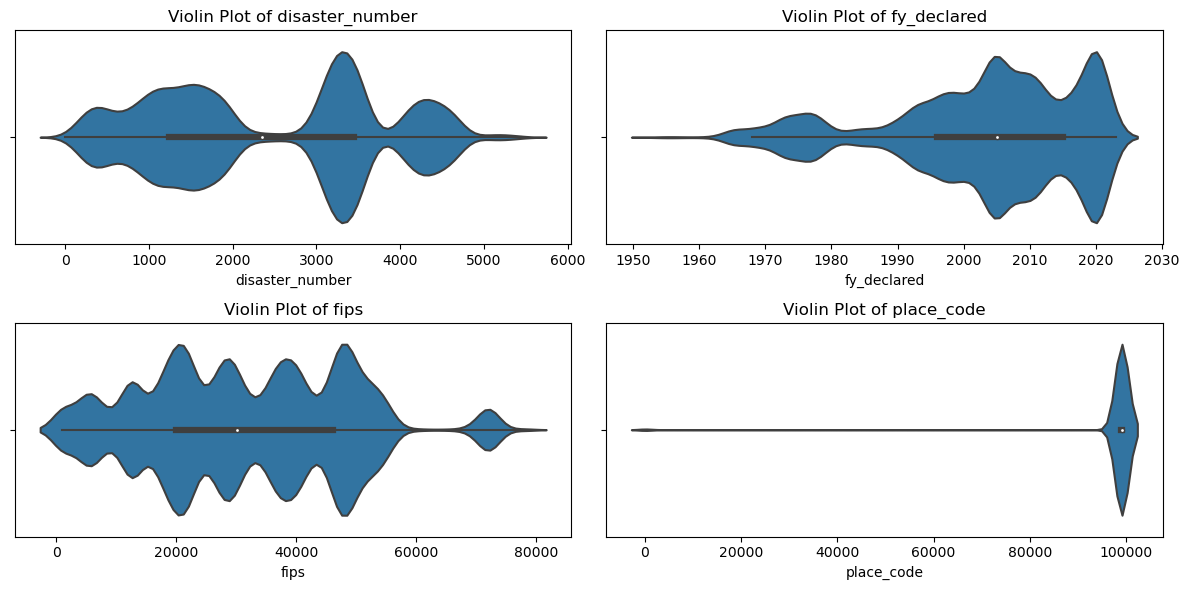

In [22]:
# use violin plot to check the outliers 
numerical_columns = ['disaster_number', 'fy_declared', 'fips', 'place_code']

plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_columns, 1):
    # Set up subplot grid with 2 rows and 2 columns, and select the ith subplot
    plt.subplot(2, 2, i)
    #Create a violin plot for the current numerical column
    sns.violinplot(x=dataset[column])
    plt.title(f'Violin Plot of {column}')
plt.tight_layout()
plt.show()


##### Drop the 0 value for place_code, fips, declaration_request_number, disaster_number, and fy_declared because they are considered outliers.

In [23]:
dataset = dataset[(dataset['place_code'] != 0) & 
                  (dataset['fips'] != 0) & 
                  (dataset['declaration_request_number'] != 0) & 
                  (dataset['disaster_number'] != 0) & 
                  (dataset['fy_declared'] != 0)]

In [24]:
dataset.count()

fema_declaration_string       59016
disaster_number               59016
state                         59016
declaration_type              59016
declaration_date              59016
fy_declared                   59016
incident_type                 59016
declaration_title             59016
ih_program_declared           59016
ia_program_declared           59016
pa_program_declared           59016
hm_program_declared           59016
incident_begin_date           59016
incident_end_date             59016
disaster_closeout_date        59016
fips                          59016
place_code                    59016
designated_area               59016
declaration_request_number    59016
dtype: int64

##### This code makes a graph of the Z-scores for certain groups of numbers in a dataset. You can find out how far away a data point is from the dataset's mean by its Z-score. Using standard deviations from the mean to figure out Z-scores for numerical fields lets us find outliers and see how the data is spread out.

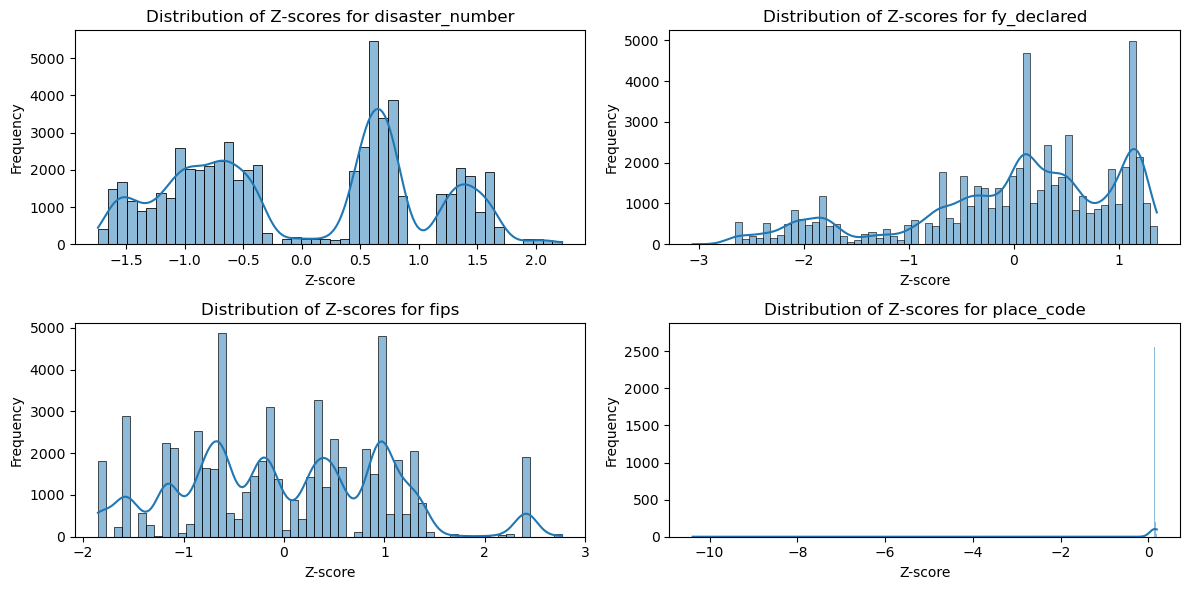

In [25]:
# This code plots the distribution of Z-scores for specific numerical columns, helping to detect outliers and understand data distribution.
numerical_columns = ['disaster_number', 'fy_declared', 'fips', 'place_code']

# Calculate Z-scores for the numerical columns
z_scores = dataset[numerical_columns].apply(stats.zscore)

plt.figure(figsize=(12, 6))
# Iterate over each numerical column
for i, column in enumerate(numerical_columns, 1):
    # Create a subplot for the current numerical column
    plt.subplot(2, 2, i)
    # Plot the histogram of Z-scores with KDE (Kernel Density Estimation)
    sns.histplot(z_scores[column], kde=True)
    plt.title(f'Distribution of Z-scores for {column}')
    plt.xlabel('Z-score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### CONTAMINATED DATA

In [26]:
dataset.count()

fema_declaration_string       59016
disaster_number               59016
state                         59016
declaration_type              59016
declaration_date              59016
fy_declared                   59016
incident_type                 59016
declaration_title             59016
ih_program_declared           59016
ia_program_declared           59016
pa_program_declared           59016
hm_program_declared           59016
incident_begin_date           59016
incident_end_date             59016
disaster_closeout_date        59016
fips                          59016
place_code                    59016
designated_area               59016
declaration_request_number    59016
dtype: int64

##### The code filters out rows where the incident's begin date is after the end date. This ensures logical consistency, as an incident cannot start after it ends. The filtering ensures valid data for accurate analysis and interpretation.

In [27]:
# remove the illogical date 
dataset = dataset[(dataset['incident_begin_date'] <= dataset['incident_end_date']) & 
                  (dataset['incident_begin_date'] <= dataset['disaster_closeout_date']) &
                  (dataset['incident_end_date'] >= dataset['incident_begin_date']) &
                  (dataset['incident_end_date'] <= dataset['disaster_closeout_date']) &
                  (dataset['disaster_closeout_date'] >= dataset['incident_begin_date']) &
                  (dataset['disaster_closeout_date'] >= dataset['incident_end_date'])]

In [28]:
dataset.count()

fema_declaration_string       58944
disaster_number               58944
state                         58944
declaration_type              58944
declaration_date              58944
fy_declared                   58944
incident_type                 58944
declaration_title             58944
ih_program_declared           58944
ia_program_declared           58944
pa_program_declared           58944
hm_program_declared           58944
incident_begin_date           58944
incident_end_date             58944
disaster_closeout_date        58944
fips                          58944
place_code                    58944
designated_area               58944
declaration_request_number    58944
dtype: int64

### INCONSISTENT DATA

##### The code converts date columns in the dataset to datetime format and then prints the updated data types.

In [29]:
# convert the data type 
dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date']).dt.strftime('%Y-%m-%d')
dataset['incident_begin_date'] = pd.to_datetime(dataset['incident_begin_date']).dt.strftime('%Y-%m-%d')
dataset['incident_end_date'] = pd.to_datetime(dataset['incident_end_date']).dt.strftime('%Y-%m-%d')
dataset['disaster_closeout_date'] = pd.to_datetime(dataset['disaster_closeout_date']).dt.strftime('%Y-%m-%d')

dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date'])
dataset['incident_begin_date'] = pd.to_datetime(dataset['incident_begin_date'])
dataset['incident_end_date'] = pd.to_datetime(dataset['incident_end_date'])
dataset['disaster_closeout_date'] = pd.to_datetime(dataset['disaster_closeout_date'])

print(dataset.dtypes)

fema_declaration_string               object
disaster_number                        int64
state                                 object
declaration_type                      object
declaration_date              datetime64[ns]
fy_declared                            int64
incident_type                         object
declaration_title                     object
ih_program_declared                    int64
ia_program_declared                    int64
pa_program_declared                    int64
hm_program_declared                    int64
incident_begin_date           datetime64[ns]
incident_end_date             datetime64[ns]
disaster_closeout_date        datetime64[ns]
fips                                   int64
place_code                             int64
designated_area                       object
declaration_request_number             int64
dtype: object


In [30]:
dataset.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number
89,DR-91-IN,91,IN,DR,1959-01-29,1959,Flood,Flood,0,1,1,0,1959-01-29,1959-01-29,1960-11-01,18021,99021,Clay (County),59015
181,DR-184-OR,184,OR,DR,1964-12-24,1965,Flood,Heavy Rains & Flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41001,99001,Baker (County),64031
182,DR-184-OR,184,OR,DR,1964-12-24,1965,Flood,Heavy Rains & Flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41003,99003,Benton (County),64031
183,DR-184-OR,184,OR,DR,1964-12-24,1965,Flood,Heavy Rains & Flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41005,99005,Clackamas (County),64031
184,DR-184-OR,184,OR,DR,1964-12-24,1965,Flood,Heavy Rains & Flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41007,99007,Clatsop (County),64031


##### The code converts specific columns in the dataset to lowercase and displays the first few rows of the updated dataset. By converting all text data to lowercase, potential inconsistencies due to variations in capitalization are mitigated. 

In [31]:
# convert everything to lower case 
dataset['fema_declaration_string'] = dataset['fema_declaration_string'].str.lower()
dataset['state'] = dataset['state'].str.lower()
dataset['declaration_type'] = dataset['declaration_type'].str.lower()
dataset['incident_type'] = dataset['incident_type'].str.lower()
dataset['declaration_title'] = dataset['declaration_title'].str.lower()
dataset['designated_area'] = dataset['designated_area'].str.lower()

dataset.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number
89,dr-91-in,91,in,dr,1959-01-29,1959,flood,flood,0,1,1,0,1959-01-29,1959-01-29,1960-11-01,18021,99021,clay (county),59015
181,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41001,99001,baker (county),64031
182,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41003,99003,benton (county),64031
183,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41005,99005,clackamas (county),64031
184,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41007,99007,clatsop (county),64031


### INVALID DATA

In [32]:
dataset.count()

fema_declaration_string       58944
disaster_number               58944
state                         58944
declaration_type              58944
declaration_date              58944
fy_declared                   58944
incident_type                 58944
declaration_title             58944
ih_program_declared           58944
ia_program_declared           58944
pa_program_declared           58944
hm_program_declared           58944
incident_begin_date           58944
incident_end_date             58944
disaster_closeout_date        58944
fips                          58944
place_code                    58944
designated_area               58944
declaration_request_number    58944
dtype: int64

In [33]:
dataset.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number
89,dr-91-in,91,in,dr,1959-01-29,1959,flood,flood,0,1,1,0,1959-01-29,1959-01-29,1960-11-01,18021,99021,clay (county),59015
181,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41001,99001,baker (county),64031
182,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41003,99003,benton (county),64031
183,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41005,99005,clackamas (county),64031
184,dr-184-or,184,or,dr,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41007,99007,clatsop (county),64031


##### The purpose of this code snippet is to identify and highlight columns in a dataset that contain values with parentheses. By doing so, it helps to flag potential inconsistencies or irregularities in the data, allowing for further investigation or data cleansing if necessary.

In [34]:
# to view the data that consist unnecessary data
columns_with_parentheses = []

# Iterate over each column in the dataset
for column in dataset.columns:
    # Check if any value in the column contains parentheses
    if dataset[column].apply(lambda x: '(' in str(x) and ')' in str(x)).any():
        # Add the column to the list if it contains parentheses
        columns_with_parentheses.append(column)

# Print the count of unique values containing parentheses for each column
for column in columns_with_parentheses:
    # Extract values containing parentheses in the column
    values_with_parentheses = dataset[column][dataset[column].apply(lambda x: '(' in str(x) and ')' in str(x))]
    unique_values = values_with_parentheses.unique()
    print(f"Column '{column}' has {len(unique_values)} unique values containing parentheses.")
    print("Unique values:")
    print(unique_values)


Column 'declaration_title' has 13 unique values containing parentheses.
Unique values:
['fire (city of chelsea)' 'floodng (nys barge canal)'
 'tornadoes, flooding torrential rain(trop storm alberto)'
 'severe storms and flooding (tropical storm alberto)'
 'the el nino (the salmon industry)' 'blizzard of 96 (severe snow storm)'
 'debruce grain elevator explosion  (sedgwick cty)'
 'nv wildfire (pioche) 06-08-2002'
 'ca - wildfire (pacific fire) - 01-06-2003'
 'az-wildfire (edge complex) 07-22-2005' 'parks highway (tamarack) fire'
 'blanco (cr 4901) fire' 'lehigh acres (anna ave. n.) fire']
Column 'designated_area' has 2210 unique values containing parentheses.
Unique values:
['clay (county)' 'baker (county)' 'benton (county)' ...
 'trescott (township of)' 'juneau (borough)'
 'rohnerville rancheria (indian reservation)']


##### This is the code removes parentheses and their contents from the 'declaration_title' and 'designated_area' columns in the dataset. After removal, it retrieves and prints the unique values in these columns to observe the changes. Finally, it assigns the modified dataset back to itself, although this step is optional. This process helps to clean and standardize the data, removing unnecessary information contained within parentheses.

In [35]:
# Remove parentheses and their contents from 'declaration_title' column
dataset['declaration_title'] = dataset['declaration_title'].str.replace(r'\(.*?\)', '')

# Define a function to remove parentheses and their contents from 'designated_area' column
def remove_parentheses(text):
    return text.split('(')[0].strip()

# Apply the function to 'designated_area' column
dataset['designated_area'] = dataset['designated_area'].apply(lambda x: remove_parentheses(x) if '(' in x else x)

# Get unique values in 'declaration_title' and 'designated_area' after removal
unique_declaration_titles = dataset['declaration_title'].dropna().unique()
unique_designated_areas = dataset['designated_area'].dropna().unique()

# Print unique values after removal
print("Unique declaration titles after removal:")
print(unique_declaration_titles)

print("Unique designated areas after removal:")
print(unique_designated_areas)

# Assign the modified dataset back to itself (optional)
dataset = dataset

Unique declaration titles after removal:
['flood' 'heavy rains & flooding' 'severe storms, heavy rains & flooding'
 ... 'tropical storm nicole' 'hurricane nicole'
 'severe winter storm, snowstorm, and straight-line winds']
Unique designated areas after removal:
['clay' 'baker' 'benton' ... 'miccosukee indian reservation'
 'seminole indian trust lands' 'rohnerville rancheria']


##### The provided code defines a function, extract_dates_in_parentheses, which extracts dates enclosed within parentheses from a given value using regular expressions. It then applies this function to the 'declaration_title' column to identify values containing dates in parentheses. For each identified value, it prints the extracted dates along with the original value. This process helps to identify and inspect data entries where dates are included in parentheses within the 'declaration_title' column.

In [36]:
# check the data that consist unnecessary date 
def extract_dates_in_parentheses(value):
    return re.findall(r'\((.*?)\)', str(value))

# Check 'declaration_title' column for values containing dates in parentheses
values_with_dates = dataset['declaration_title'].apply(extract_dates_in_parentheses)
# Filter values with dates in parentheses
values_with_dates = values_with_dates[values_with_dates.apply(len) > 0]
for dates_in_parentheses in values_with_dates:
    print(f"Value '{dates_in_parentheses[0]}' in 'declaration_title' column contains date(s) in parentheses: {dates_in_parentheses}")

Value 'city of chelsea' in 'declaration_title' column contains date(s) in parentheses: ['city of chelsea']
Value 'nys barge canal' in 'declaration_title' column contains date(s) in parentheses: ['nys barge canal']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alberto']
Value 'trop storm alberto' in 'declaration_title' column contains date(s) in parentheses: ['trop storm alber

##### The purpose of the code snippet is to delete dates that appear within parentheses from the 'declaration_title' column in the dataset. This is done to ensure data consistency and cleanliness, as the presence of dates within parentheses may not be relevant to the analysis and could potentially lead to inconsistencies or errors in downstream processing.

In [37]:
# Function to remove dates in parentheses from a string
def remove_dates_in_parentheses(value):
    return re.sub(r'\(.*?\)', '', str(value))

# Remove dates in parentheses from 'declaration_title' column
dataset['declaration_title'] = dataset['declaration_title'].apply(remove_dates_in_parentheses)

dataset = dataset


### DUPLICATE DATA

##### This code ensures that the dataset is free from duplicates, and upon verification, it confirms that no duplicate entries exist.

In [38]:
print("Number of rows before removing duplicates:", dataset.shape[0])

# Drop duplicates
dataset = dataset.drop_duplicates()

# Print number of rows after removing duplicates
print("Number of rows after removing duplicates:", dataset.shape[0])


Number of rows before removing duplicates: 58944
Number of rows after removing duplicates: 58944


### DATA TYPE ISSUES

##### Check datatype 

In [39]:
print(dataset.dtypes)

fema_declaration_string               object
disaster_number                        int64
state                                 object
declaration_type                      object
declaration_date              datetime64[ns]
fy_declared                            int64
incident_type                         object
declaration_title                     object
ih_program_declared                    int64
ia_program_declared                    int64
pa_program_declared                    int64
hm_program_declared                    int64
incident_begin_date           datetime64[ns]
incident_end_date             datetime64[ns]
disaster_closeout_date        datetime64[ns]
fips                                   int64
place_code                             int64
designated_area                       object
declaration_request_number             int64
dtype: object


##### To check which column is suitable for encoding

In [40]:
# Get the count of unique values for each column
unique_counts = dataset.nunique()

# Print the count of unique values for each column
print("Count of unique values for each column:")
print(unique_counts)


Count of unique values for each column:
fema_declaration_string       4090
disaster_number               4090
state                           59
declaration_type                 3
declaration_date              2921
fy_declared                     60
incident_type                   25
declaration_title             1869
ih_program_declared              2
ia_program_declared              2
pa_program_declared              2
hm_program_declared              2
incident_begin_date           2668
incident_end_date             2848
disaster_closeout_date        2148
fips                          3299
place_code                     794
designated_area               2351
declaration_request_number    4090
dtype: int64


##### The purpose of this code is to convert the categorical values in the 'declaration_type' column to numerical representations for better analysis and modeling. This is achieved by mapping specific declaration types ('dr', 'em', 'fm') to corresponding numerical values (1, 2, 3) using a predefined dictionary (declaration_type_map). After the conversion, the modified dataset is displayed to show the changes.

In [41]:
# convert the type to 1, 2, 3  
declaration_type_map = {"dr": 1, "em": 2, "fm": 3}

dataset['declaration_type'] = dataset['declaration_type'].replace(declaration_type_map)

dataset.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number
89,dr-91-in,91,in,1,1959-01-29,1959,flood,flood,0,1,1,0,1959-01-29,1959-01-29,1960-11-01,18021,99021,clay,59015
181,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41001,99001,baker,64031
182,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41003,99003,benton,64031
183,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41005,99005,clackamas,64031
184,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41007,99007,clatsop,64031


### STRUCTURAL ERRORS

##### We've successfully concluded our data cleaning endeavor by eliminating duplicates, managing missing values, and addressing structural errors. As we proceed, it's imperative to review our engineering best practices, particularly within our ETL pipeline, to identify and rectify any sources of structural errors. This proactive approach will ensure the integrity and reliability of our data moving forward.

# DATA VISUALISATION

Firstly, creates a bar chart using seaborn and matplotlib to display the count of different incident types per state. It sets the figure size, rotates the x-axis labels for better readability, and then shows the plot.

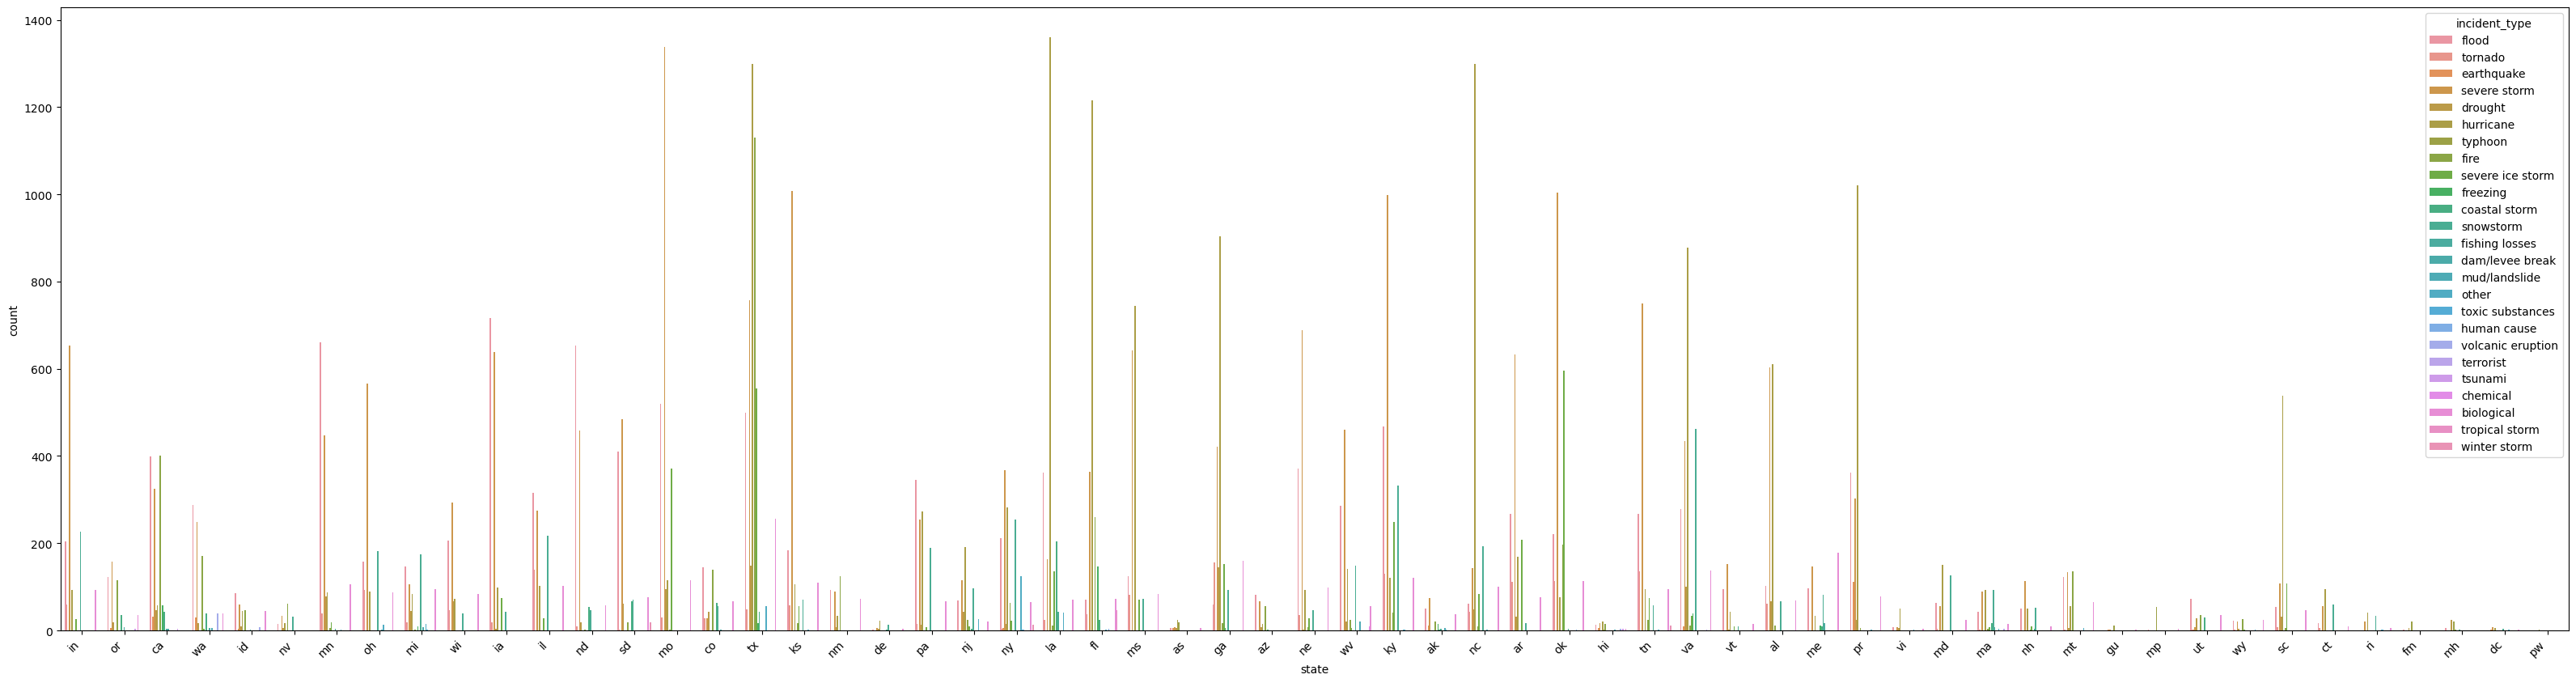

In [42]:
plt.figure(figsize=(40, 10))  # Adjust the width and height as needed

# Use countplot to visualize the count of incident types per state
plot = sns.countplot(x="state", hue="incident_type", data=dataset)

# Rotate x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.show()


Remove the high volume variables states with high specific incident type. This will make the graph more visible on it. 

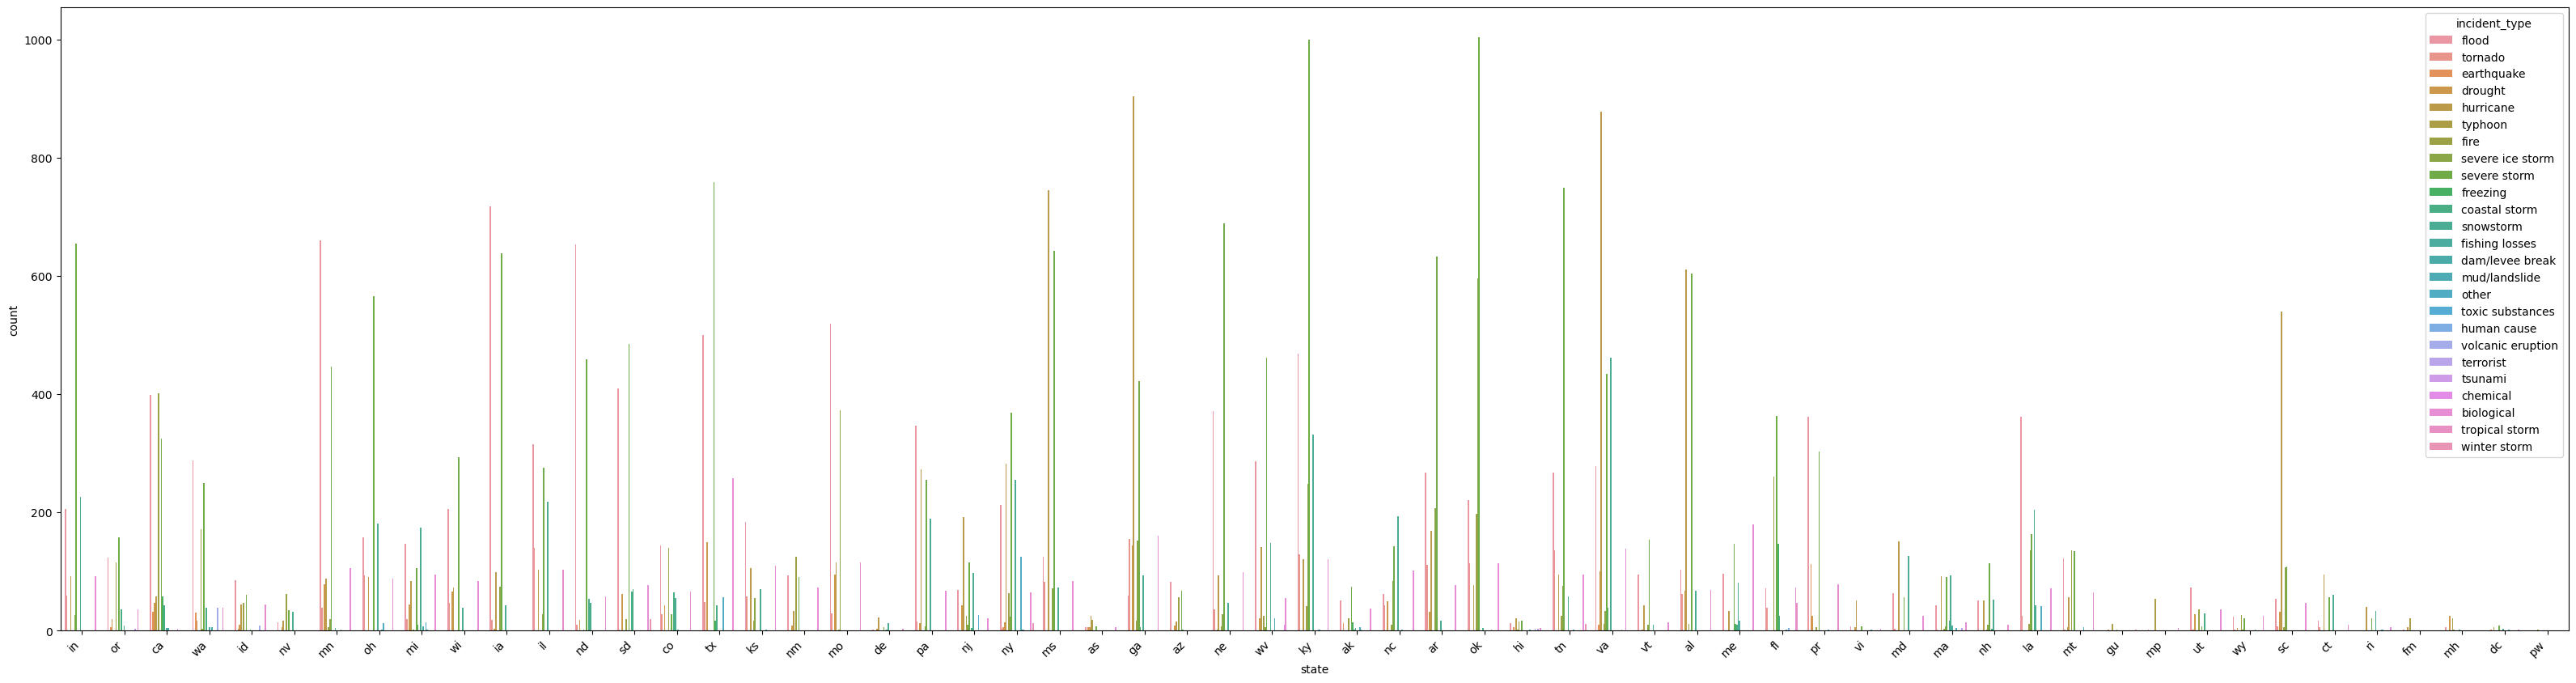

In [43]:
# Define the states and incident types to be removed
states_incident_to_remove = {
    'la': ['hurricane'],
    'mo': ['severe storm'],
    'tx': ['severe ice storm', 'fire','hurricane'],
    'ks': ['severe storm'],
    'fl': ['hurricane'],
    'nc': ['hurricane'], 
    'pr': ['hurricane']
}  # Add the states and incident types you want to remove

# Filter the dataset to exclude the specified states and incident types
filtered_dataset = dataset.copy()  # Make a copy of the dataset to avoid modifying the original
for state, incident_types in states_incident_to_remove.items():
    filtered_dataset = filtered_dataset[~((filtered_dataset['state'] == state) & 
                                          (filtered_dataset['incident_type'].isin(incident_types)))]

plt.figure(figsize=(40, 10))  # Adjust the width and height as needed

# Use countplot to visualize the count of incident types per state after filtering
plot = sns.countplot(x="state", hue="incident_type", data=filtered_dataset)

# Rotate x-axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.show()


### Time Series Plot

Generates a time series plot using matplotlib to visualize the count of natural disaster declarations over time, categorized by incident type. It first converts the 'declaration_date' column to datetime format. Then, it groups the data by month and incident type, calculates the count of each type, and creates a time series plot. The plot is customized with a title, labels for the x and y axes, a legend showing the incident types, and adjusted layout for better visualization. Finally, it displays the plot.

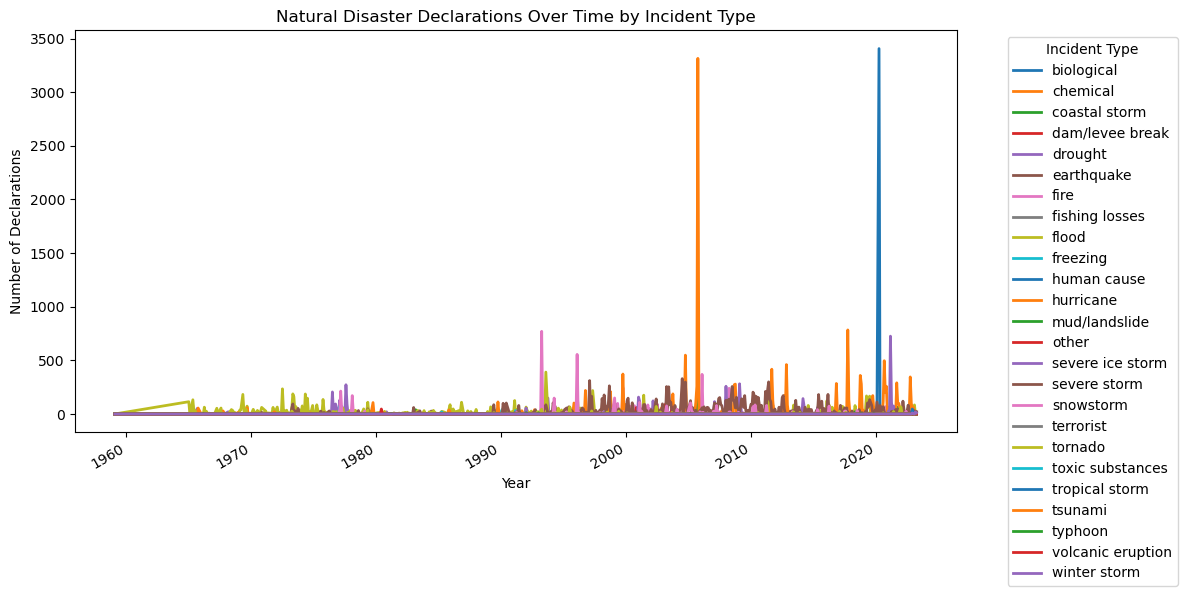

In [44]:
# Convert the 'declaration_date' column to datetime format
dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date'])

time_series_data = dataset.groupby([pd.Grouper(key='declaration_date', freq='M'), 'incident_type']).size().unstack(fill_value=0)

# Plot the time series
time_series_data.plot(figsize=(12, 6), linewidth=2)

# Set plot title and labels
plt.title('Natural Disaster Declarations Over Time by Incident Type')
plt.xlabel('Year')
plt.ylabel('Number of Declarations')

# Show legend
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()



Biological in 2020 is removed, this will leading to an clearer image of the time series plot. 

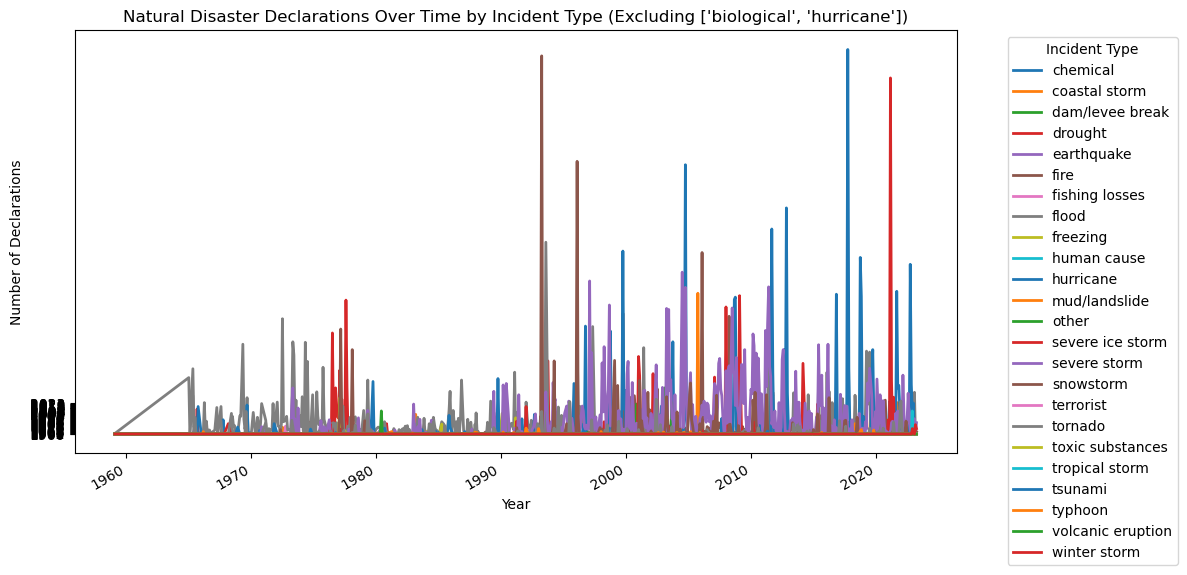

In [45]:
# Convert the 'declaration_date' column to datetime format
dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date'])

# Define the years and incident types to be removed
years_to_remove = [2020, 2005]
incident_types_to_remove = ['biological', 'hurricane']

# Filter the dataset to exclude the specified years and incident types
filtered_dataset = dataset[~((dataset['declaration_date'].dt.year.isin(years_to_remove)) &
                             (dataset['incident_type'].isin(incident_types_to_remove)))]

# Group by month and incident type
time_series_data = filtered_dataset.groupby([pd.Grouper(key='declaration_date', freq='M'), 'incident_type']).size().unstack(fill_value=0)

# Plot the time series
time_series_data.plot(figsize=(12, 6), linewidth=2)

# Set plot title and labels
plt.title('Natural Disaster Declarations Over Time by Incident Type (Excluding {})'.format(incident_types_to_remove))
plt.xlabel('Year')
plt.ylabel('Number of Declarations')

# Customize y-axis labels to display one year by one year
years = pd.date_range(start=time_series_data.index.min(), end=time_series_data.index.max(), freq='YS')
plt.yticks(ticks=range(len(years)), labels=years.strftime('%Y'))

# Show legend
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [46]:
#Dispplay different types of unique incidenet having in the dataset
unique_incident_types = dataset['incident_type'].unique()
print(unique_incident_types)


['flood' 'tornado' 'earthquake' 'severe storm' 'drought' 'hurricane'
 'typhoon' 'fire' 'severe ice storm' 'freezing' 'coastal storm'
 'snowstorm' 'fishing losses' 'dam/levee break' 'mud/landslide' 'other'
 'toxic substances' 'human cause' 'volcanic eruption' 'terrorist'
 'tsunami' 'chemical' 'biological' 'tropical storm' 'winter storm']


### Network Diagram

Network visualization of different disaster types using the networkx library in Python. It constructs a graph where each node represents a type of disaster (e.g., Flood, Tornado) and adds edges between pairs of disaster types. The edges indicate relationships or connections between different types of disasters. Finally, it draws the network graph, customizing node and edge properties such as color, size, and labels, and displays the plot with a title.


Network diagram is splited into 3 parts, this will enchnace the visibility and understanding of the graph with its relations. 

D:\Anaconda\Lib\site-packages\networkx\drawing\nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)
C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\3334547718.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


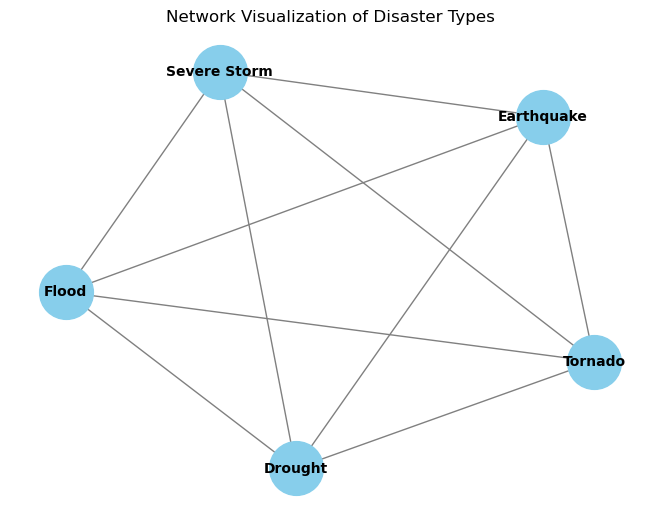

In [47]:
G = nx.Graph()

disaster_types = ['Flood', 'Tornado', 'Earthquake', 'Severe Storm', 'Drought']
G.add_nodes_from(disaster_types)

for i in range(len(disaster_types)):
    for j in range(i+1, len(disaster_types)):
        G.add_edge(disaster_types[i], disaster_types[j])

# Draw the network
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, arrowsize=20)

# Set plot title
plt.title('Network Visualization of Disaster Types')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\1549271912.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


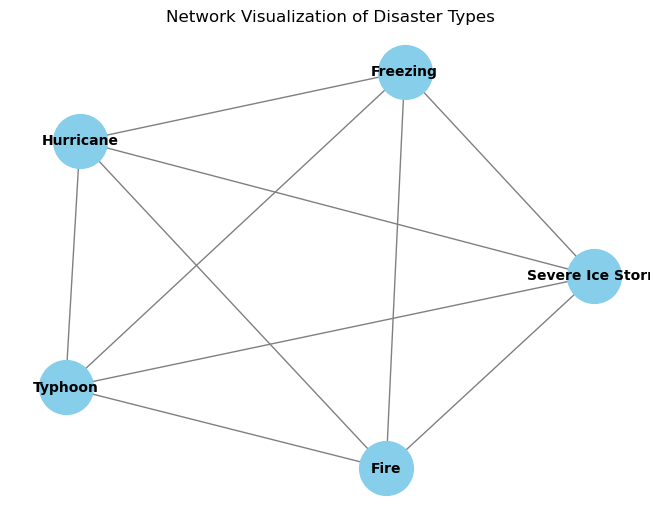

In [48]:
G = nx.Graph()

disaster_types = [ 'Hurricane', 'Typhoon', 'Fire', 'Severe Ice Storm', 'Freezing']
G.add_nodes_from(disaster_types)

for i in range(len(disaster_types)):
    for j in range(i+1, len(disaster_types)):
        G.add_edge(disaster_types[i], disaster_types[j])

# Draw the network
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, arrowsize=20)

# Set plot title
plt.title('Network Visualization of Disaster Types')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\3909988919.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


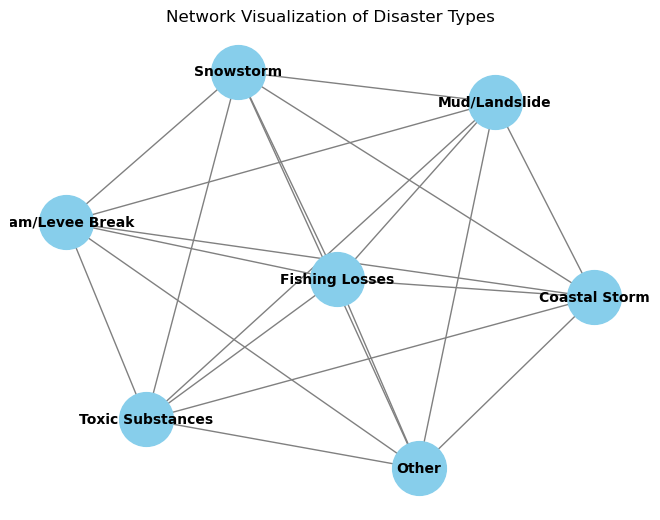

In [49]:
G = nx.Graph()

disaster_types = ['Coastal Storm', 'Snowstorm', 'Fishing Losses', 'Dam/Levee Break', 'Mud/Landslide', 'Other',
                  'Toxic Substances']

G.add_nodes_from(disaster_types)

for i in range(len(disaster_types)):
    for j in range(i+1, len(disaster_types)):
        G.add_edge(disaster_types[i], disaster_types[j])

# Draw the network
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, arrowsize=20)

# Set plot title
plt.title('Network Visualization of Disaster Types')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\2496740998.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


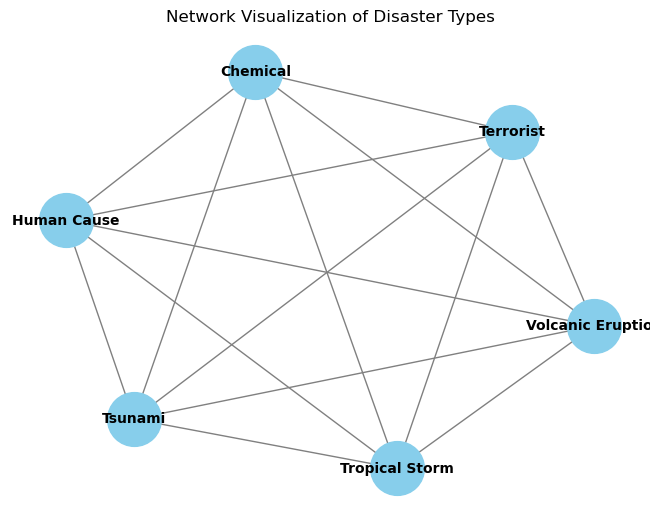

In [50]:
G = nx.Graph()

disaster_types = ['Human Cause', 'Volcanic Eruption', 'Terrorist',
                  'Tsunami', 'Chemical', 'Tropical Storm']

G.add_nodes_from(disaster_types)

for i in range(len(disaster_types)):
    for j in range(i+1, len(disaster_types)):
        G.add_edge(disaster_types[i], disaster_types[j])

# Draw the network
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, arrowsize=20)

# Set plot title
plt.title('Network Visualization of Disaster Types')

# Show plot
plt.tight_layout()
plt.show()


### Heatmap
A random relationship matrix where each cell represents the strength of the relationship between two disaster types. The heatmap displays these values, with annotations showing the exact values, and uses a color scale (YlGnBu) to represent the strength of the relationships. The x and y axis labels represent the different types of natural disasters. Finally, it displays the heatmap with a title and adjusts the layout for better visualization.

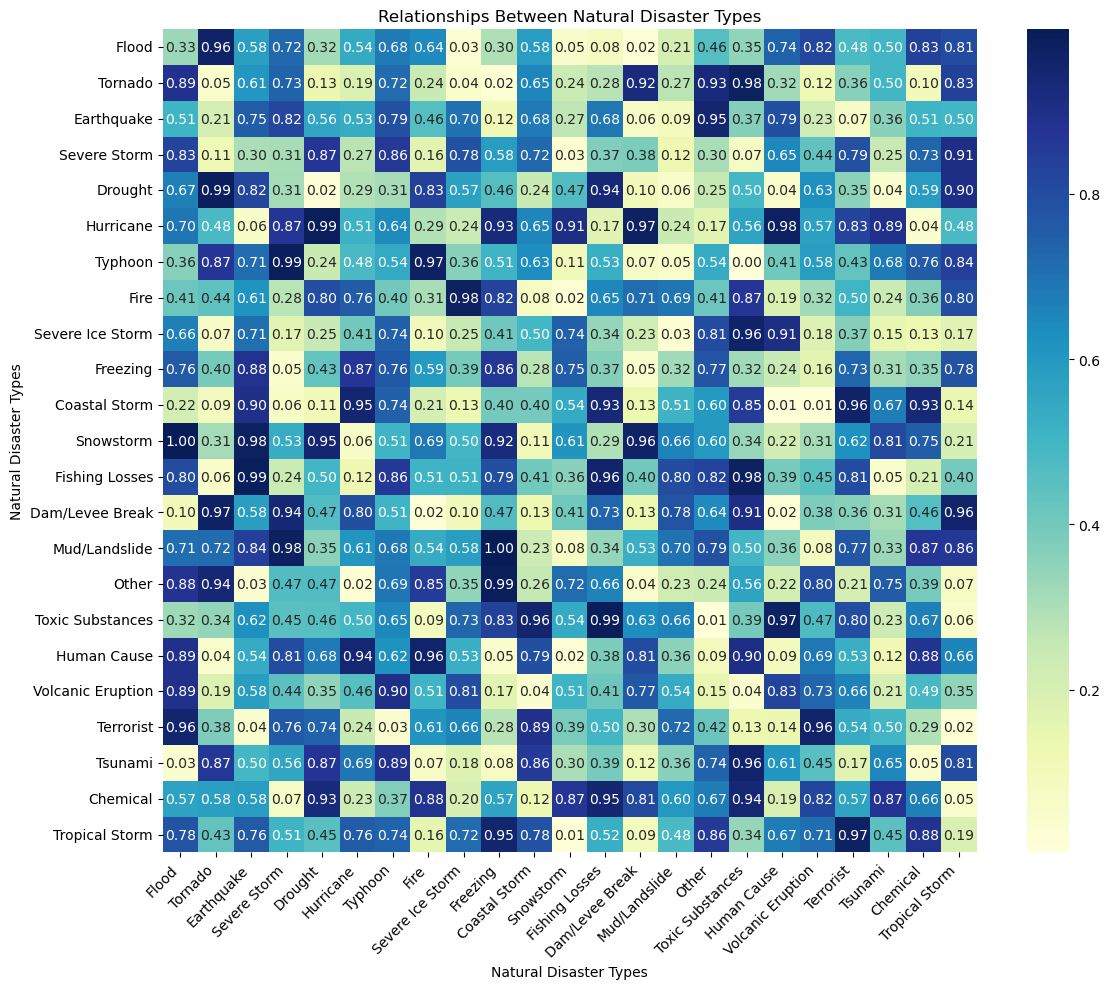

In [51]:
disaster_types = ['Flood', 'Tornado', 'Earthquake', 'Severe Storm', 'Drought', 'Hurricane',
                  'Typhoon', 'Fire', 'Severe Ice Storm', 'Freezing', 'Coastal Storm',
                  'Snowstorm', 'Fishing Losses', 'Dam/Levee Break', 'Mud/Landslide', 'Other',
                  'Toxic Substances', 'Human Cause', 'Volcanic Eruption', 'Terrorist',
                  'Tsunami', 'Chemical', 'Tropical Storm']


relationship_matrix = np.random.rand(len(disaster_types), len(disaster_types))

plt.figure(figsize=(12, 10))
sns.heatmap(relationship_matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=disaster_types, yticklabels=disaster_types)
plt.title("Relationships Between Natural Disaster Types")
plt.xlabel("Natural Disaster Types")
plt.ylabel("Natural Disaster Types")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Declaration of programs 
##### To visualizes the frequency of IH (Individuals and Households) program declarations within a dataset. It first filters the dataset to include only instances where the IH program was declared. Then, it creates two separate countplots: one displaying the frequency of IH program declarations by incident type, and the other showing the frequency by state. Each countplot is customized with appropriate titles, labels, and rotation of x-axis labels for better readability.

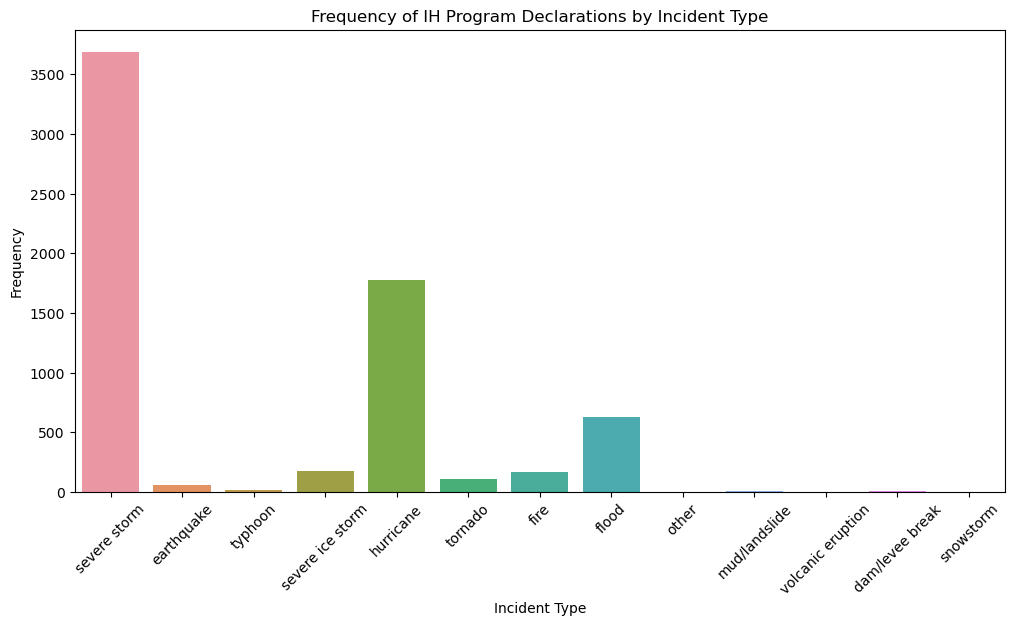

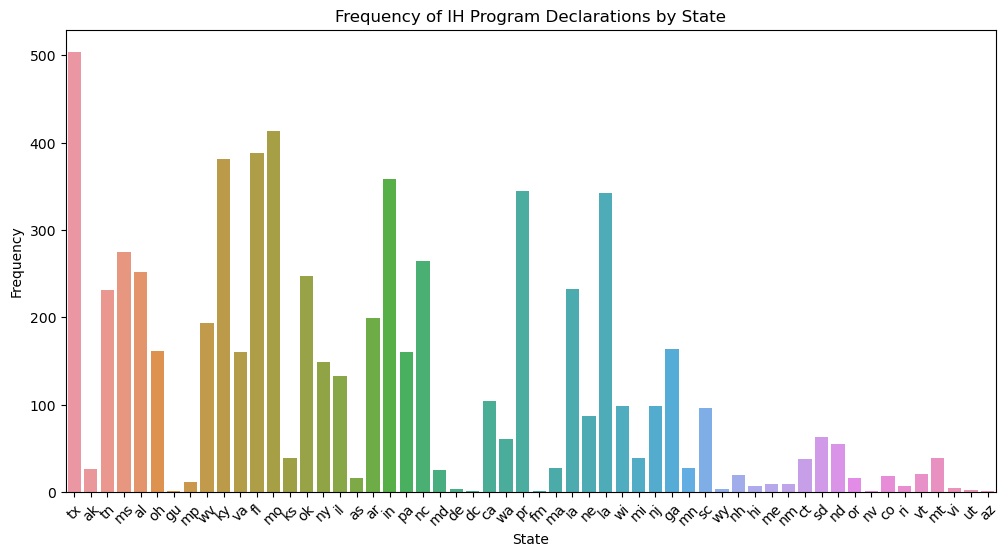

In [52]:
# Filter dataset for IH program declarations
ih_program_df = dataset[dataset['ih_program_declared'] == 1]

# Frequency of IH program declarations by incident type
plt.figure(figsize=(12, 6))
sns.countplot(x='incident_type', data=ih_program_df)
plt.title('Frequency of IH Program Declarations by Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Frequency of IH program declarations by state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=ih_program_df)
plt.title('Frequency of IH Program Declarations by State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


### Boxplot 
##### analysis and visualization on the duration of incidents within a dataset. It first calculates the duration of each incident by subtracting the incident end date from the incident begin date, then creates two separate boxplots.

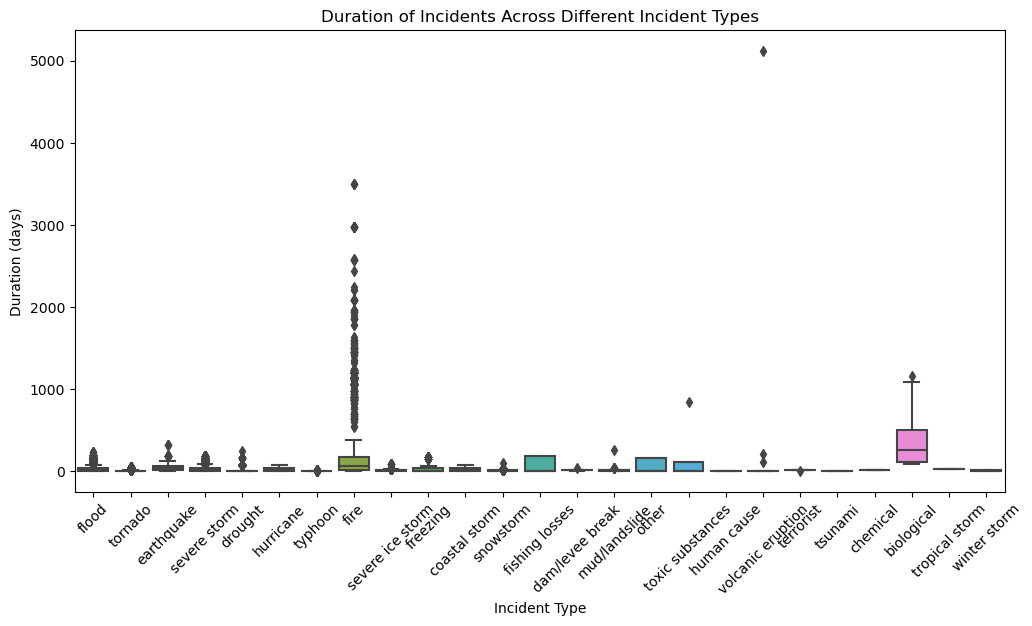

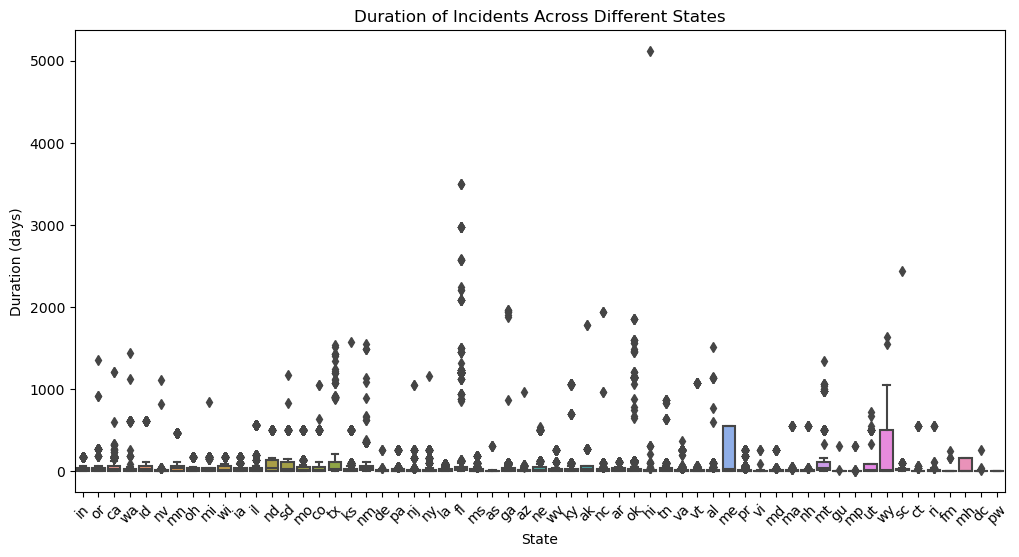

In [53]:
# Convert incident_begin_date and incident_end_date to datetime
dataset['incident_begin_date'] = pd.to_datetime(dataset['incident_begin_date'])
dataset['incident_end_date'] = pd.to_datetime(dataset['incident_end_date'])

# Calculate duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Compare the duration of incidents across different incident types
plt.figure(figsize=(12, 6))
sns.boxplot(x='incident_type', y='incident_duration', data=dataset)
plt.title('Duration of Incidents Across Different Incident Types')
plt.xlabel('Incident Type')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.show()

# Compare the duration of incidents across different states
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='incident_duration', data=dataset)
plt.title('Duration of Incidents Across Different States')
plt.xlabel('State')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.show()


Incident type of "Fire" and "Biological" are removed as they are with high frequency and higher rate of ooutliers. This will make the graph more visbible with the y axis values.

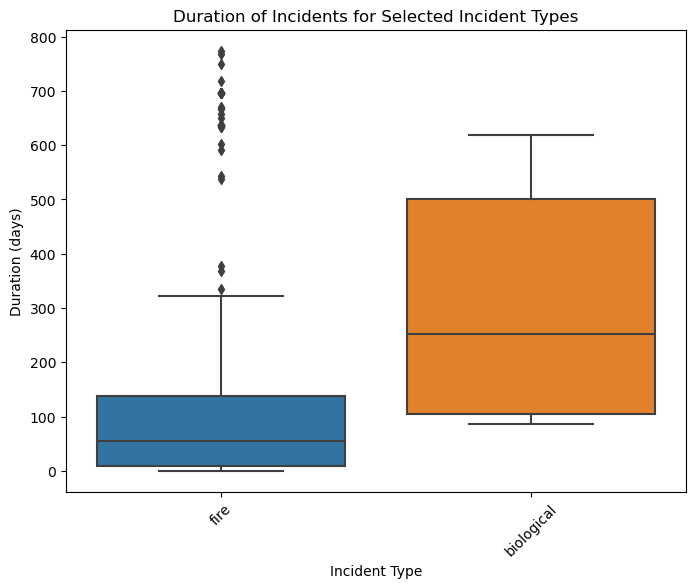

In [54]:
# Convert incident_begin_date and incident_end_date to datetime
dataset['incident_begin_date'] = pd.to_datetime(dataset['incident_begin_date'])
dataset['incident_end_date'] = pd.to_datetime(dataset['incident_end_date'])

# Calculate duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Define the two incident types to be included
incident_types_to_include = ['fire', 'biological']  # Replace with the incident types you want to include

# Filter the dataset to include only the specified incident types
filtered_dataset = dataset[dataset['incident_type'].isin(incident_types_to_include)]

# Filter the dataset to include incidents with duration up to 3000 days
filtered_dataset = filtered_dataset[filtered_dataset['incident_duration'] <= 800]

# Compare the duration of incidents across the two specified incident types
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.boxplot(x='incident_type', y='incident_duration', data=filtered_dataset)
plt.title('Duration of Incidents for Selected Incident Types')
plt.xlabel('Incident Type')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.show()


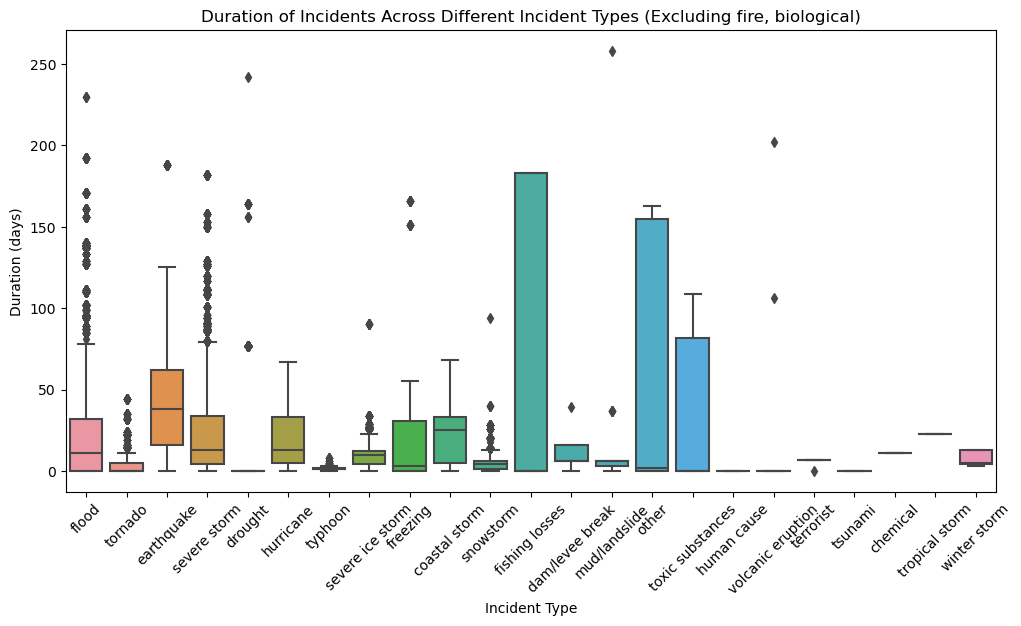

In [55]:
# Convert incident_begin_date and incident_end_date to datetime
dataset['incident_begin_date'] = pd.to_datetime(dataset['incident_begin_date'])
dataset['incident_end_date'] = pd.to_datetime(dataset['incident_end_date'])

# Calculate duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Define the incident types to be removed
incident_types_to_remove = ['fire', 'biological']  # Replace with the incident types you want to remove

# Filter the dataset to exclude incidents of the specified types
filtered_dataset = dataset[~dataset['incident_type'].isin(incident_types_to_remove)]

# Filter the dataset to include incidents with duration up to 3000 days
filtered_dataset = filtered_dataset[filtered_dataset['incident_duration'] <= 300]

# Compare the duration of incidents across different incident types (excluding the specified incident types)
plt.figure(figsize=(12, 6))
sns.boxplot(x='incident_type', y='incident_duration', data=filtered_dataset)
plt.title('Duration of Incidents Across Different Incident Types (Excluding {})'.format(', '.join(incident_types_to_remove)))
plt.xlabel('Incident Type')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.show()


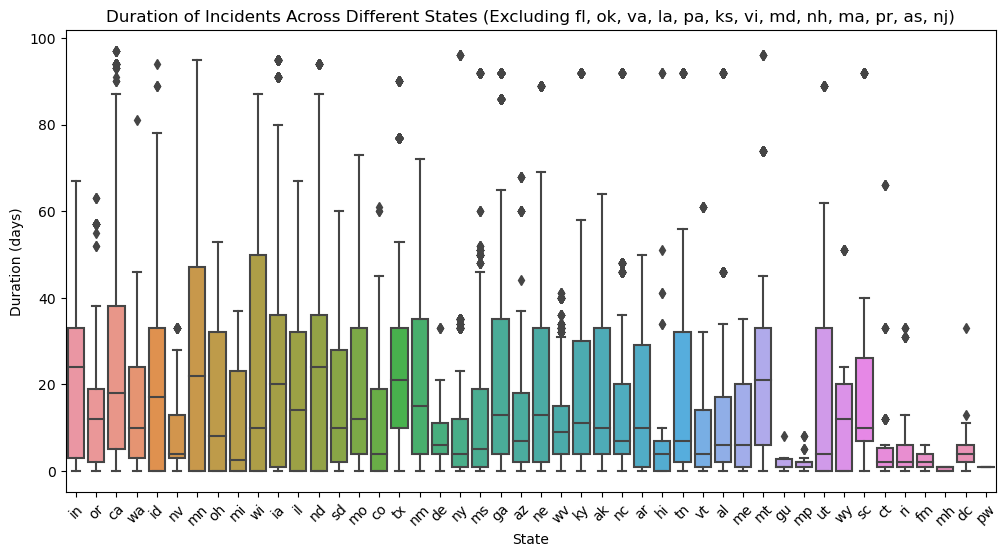

In [56]:
# Filter out NaN values in 'incident_end_date' and 'incident_begin_date'
dataset = dataset.dropna(subset=['incident_end_date', 'incident_begin_date'])

# Calculate the duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Define the states to be removed
states_to_remove = ['fl','ok','va','la','pa','ks','vi','md','nh','ma','pr','as','nj']  # Replace with the states you want to remove

# Filter the dataset to exclude incidents from the specified states
filtered_dataset = dataset[~dataset['state'].isin(states_to_remove)]

# Filter the dataset to include incidents with duration up to 3000 days
filtered_dataset = filtered_dataset[filtered_dataset['incident_duration'] <= 100]

# Create the boxplot with the filtered dataset
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='incident_duration', data=filtered_dataset)
plt.title('Duration of Incidents Across Different States (Excluding {})'.format(', '.join(states_to_remove)))
plt.xlabel('State')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.show()


### Line Plot
##### The 'declaration_date' column in the dataset to datetime format. It then groups the data by 'declaration_date' and counts the number of disasters declared for each date. A line plot is generated to visualize the trend of the number of disasters declared over time. The x-axis represents the declaration date, while the y-axis shows the corresponding count of disasters. The plot is customized with a title, axis labels, and grid lines for better interpretation.

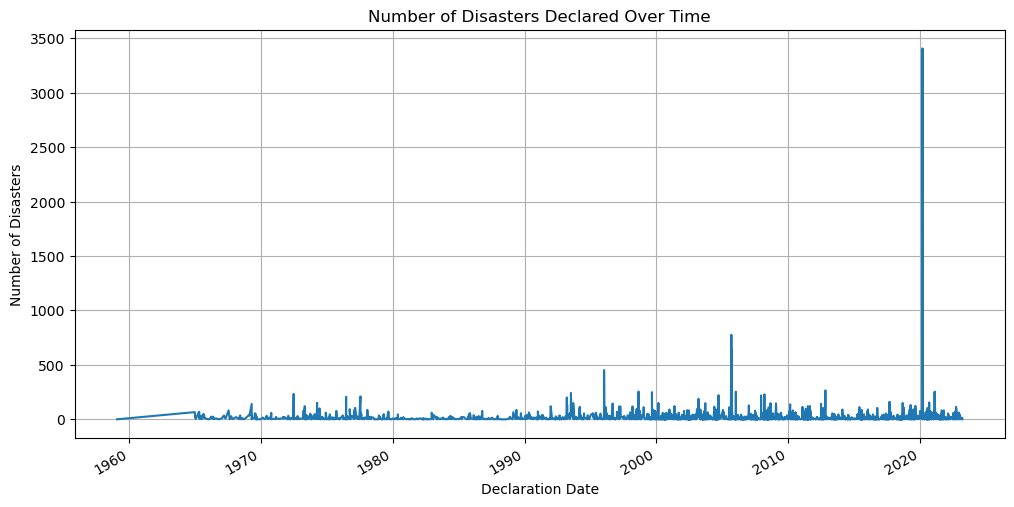

In [57]:
# Convert 'declaration_date' to datetime type
dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date'])

# Group the data by 'declaration_date' and count the number of disasters for each date
disasters_by_date = dataset.groupby('declaration_date').size()

# Plot the number of disasters declared over time
plt.figure(figsize=(12, 6))
disasters_by_date.plot()
plt.title('Number of Disasters Declared Over Time')
plt.xlabel('Declaration Date')
plt.ylabel('Number of Disasters')
plt.grid(True)
plt.show()


Years of 2020, and 2008 is removed due to its high number of diaster occuring in that particular year.

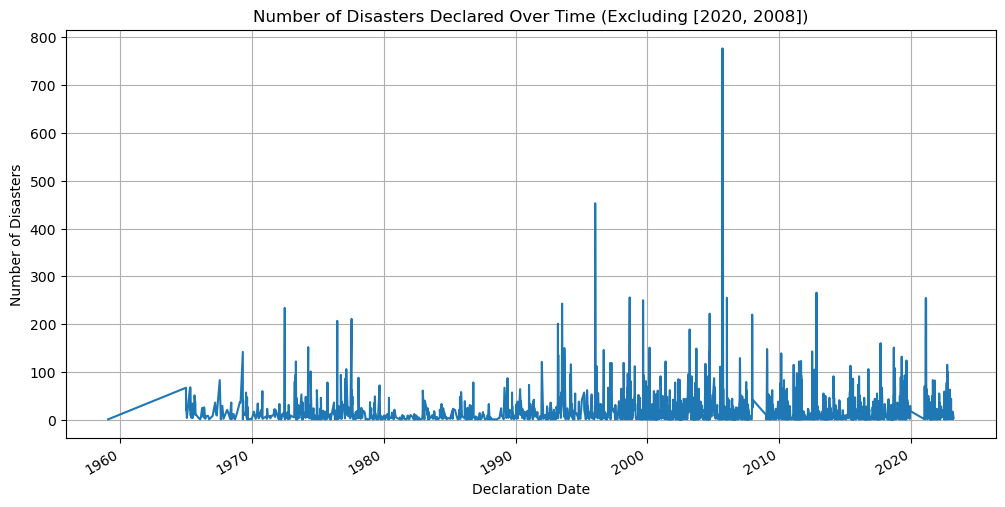

In [58]:
# Convert 'declaration_date' to datetime type
dataset['declaration_date'] = pd.to_datetime(dataset['declaration_date'])

# Define the years to be removed
years_to_remove = [2020, 2008]  # Replace with the years you want to remove

# Filter the dataset to exclude data from the specified years
filtered_dataset = dataset[~dataset['declaration_date'].dt.year.isin(years_to_remove)]

# Group the filtered data by 'declaration_date' and count the number of disasters for each date
disasters_by_date_filtered = filtered_dataset.groupby('declaration_date').size()

# Plot the number of disasters declared over time (excluding the specified years)
plt.figure(figsize=(12, 6))
disasters_by_date_filtered.plot()
plt.title('Number of Disasters Declared Over Time (Excluding {})'.format(years_to_remove))
plt.xlabel('Declaration Date')
plt.ylabel('Number of Disasters')
plt.grid(True)
plt.show()


### Violin Plot 
##### a violin plot is generated where each violin represents the distribution of incident durations for a specific incident type

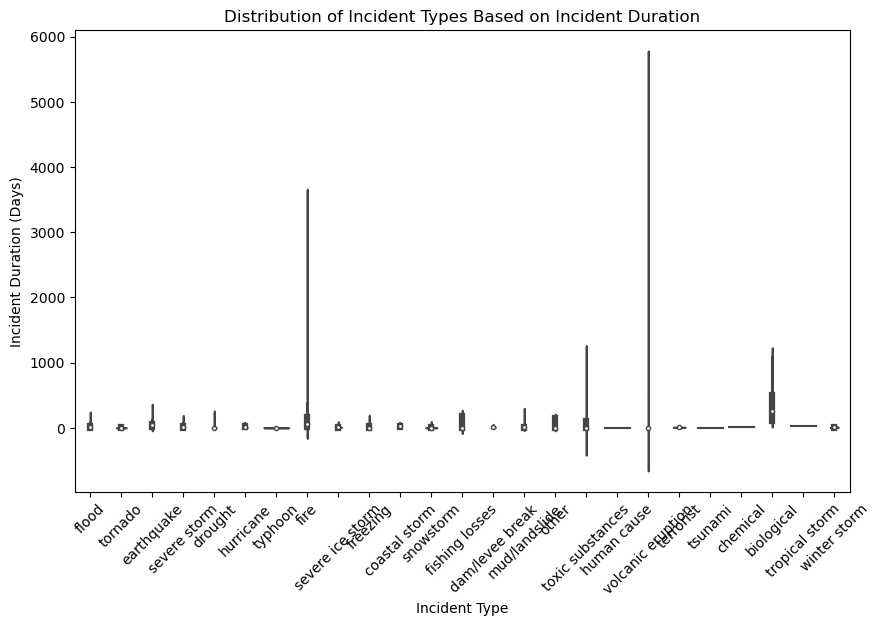

In [59]:
# Filter out NaN values in 'incident_end_date' and 'incident_begin_date'
dataset = dataset.dropna(subset=['incident_end_date', 'incident_begin_date'])

# Calculate the duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='incident_type', y='incident_duration', data=dataset)
plt.title('Distribution of Incident Types Based on Incident Duration')
plt.xlabel('Incident Type')
plt.ylabel('Incident Duration (Days)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


Types of incident type is removed and added seperated into different graph for a clearer picture. 

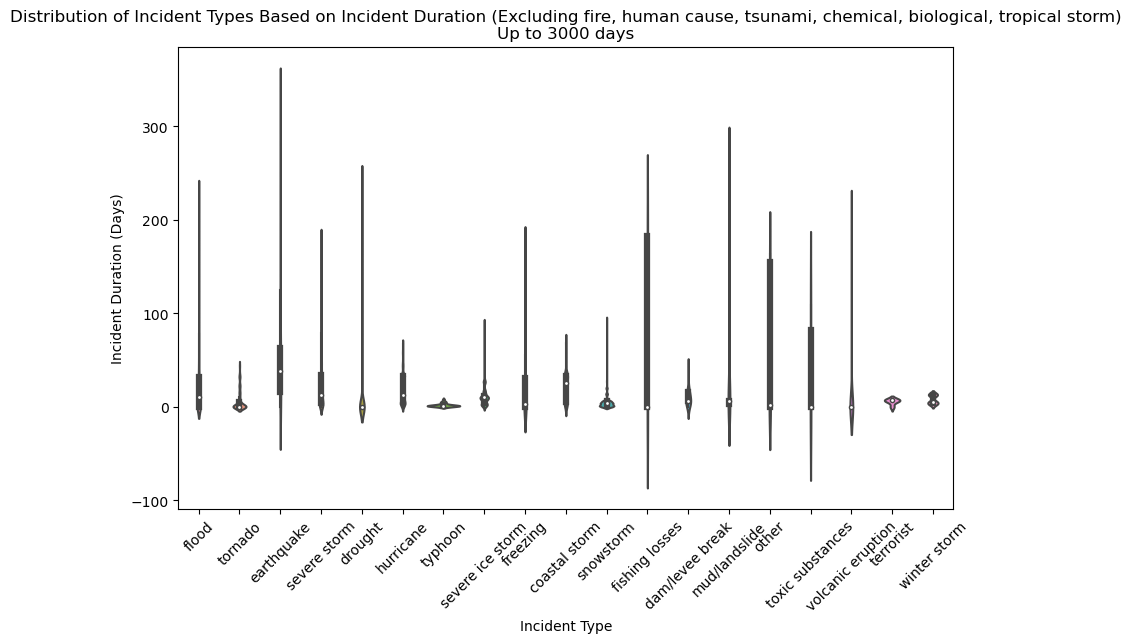

In [60]:
# Filter out NaN values in 'incident_end_date' and 'incident_begin_date'
dataset = dataset.dropna(subset=['incident_end_date', 'incident_begin_date'])

# Calculate the duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Define the incident types to be removed
incident_types_to_remove = ['fire', 'human cause','tsunami','chemical','biological','tropical storm']  # Replace with the incident types you want to remove

# Filter the dataset to exclude incidents of the specified types
filtered_dataset = dataset[~dataset['incident_type'].isin(incident_types_to_remove)]

# Filter the dataset to include incidents with duration up to 3000 days
filtered_dataset = filtered_dataset[filtered_dataset['incident_duration'] <= 500]

# Create the violin plot with the filtered dataset
plt.figure(figsize=(10, 6))
sns.violinplot(x='incident_type', y='incident_duration', data=filtered_dataset)
plt.title('Distribution of Incident Types Based on Incident Duration (Excluding {})\nUp to 3000 days'.format(', '.join(incident_types_to_remove)))
plt.xlabel('Incident Type')
plt.ylabel('Incident Duration (Days)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


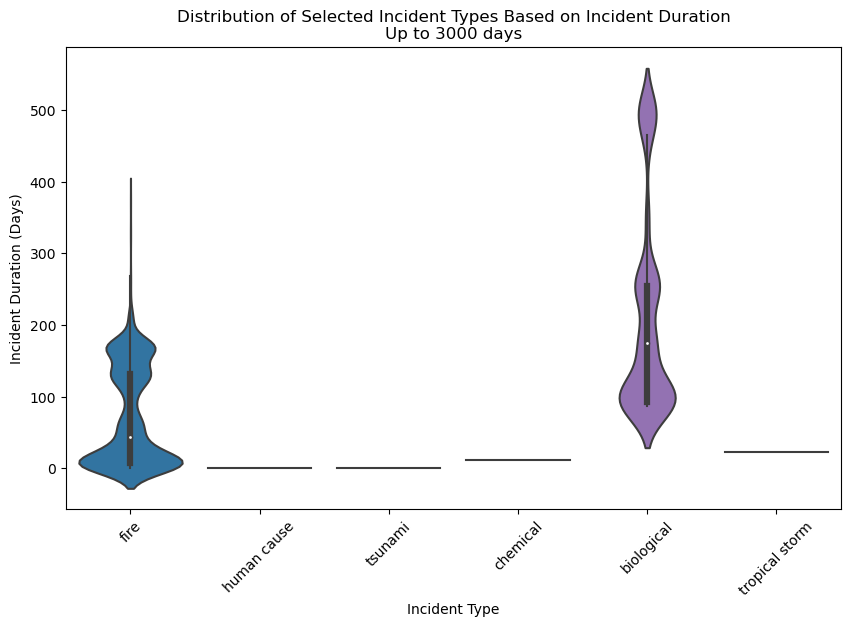

In [61]:
# Filter out NaN values in 'incident_end_date' and 'incident_begin_date'
dataset = dataset.dropna(subset=['incident_end_date', 'incident_begin_date'])

# Calculate the duration of incidents
dataset['incident_duration'] = (dataset['incident_end_date'] - dataset['incident_begin_date']).dt.days

# Define the incident types to be included
incident_types_to_keep = ['fire', 'human cause','tsunami','chemical','biological','tropical storm']  # Replace with the incident types you want to keep

# Filter the dataset to only include incidents of the specified types
filtered_dataset = dataset[dataset['incident_type'].isin(incident_types_to_keep)]

# Filter the dataset to include incidents with duration up to 3000 days
filtered_dataset = filtered_dataset[filtered_dataset['incident_duration'] <= 500]

# Create the violin plot with the filtered dataset
plt.figure(figsize=(10, 6))
sns.violinplot(x='incident_type', y='incident_duration', data=filtered_dataset)
plt.title('Distribution of Selected Incident Types Based on Incident Duration\nUp to 3000 days')
plt.xlabel('Incident Type')
plt.ylabel('Incident Duration (Days)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


### Horizontal Bar
##### creates a horizontal bar plot to visualize the distribution of incident types within a dataset. It first calculates the frequency of each incident type using the value_counts() function. Then, it creates a horizontal bar plot (kind='barh') where each incident type is represented on the y-axis and its frequency on the x-axis.

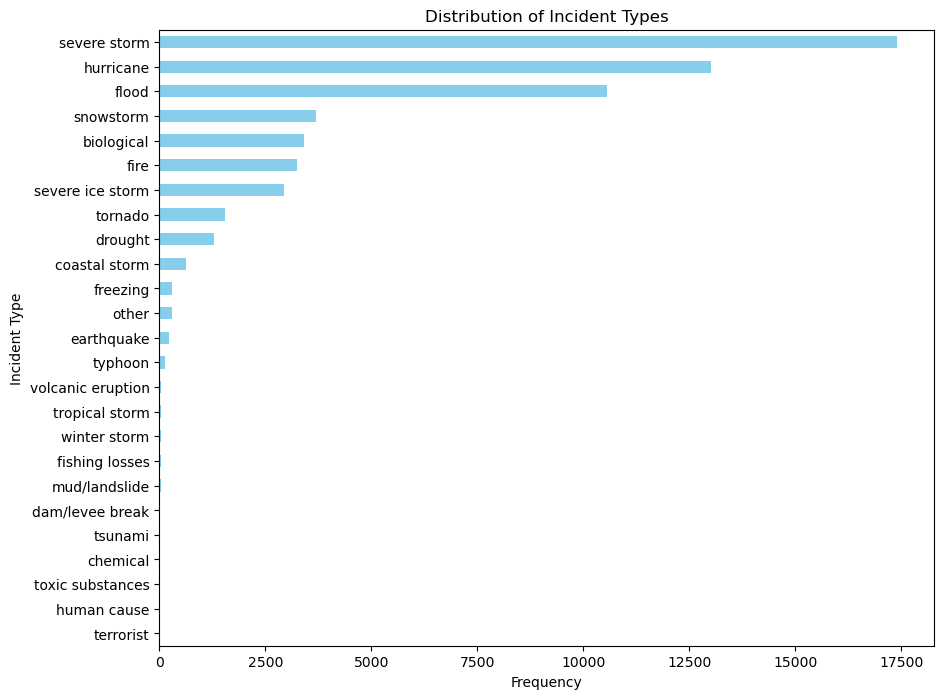

In [62]:
incident_type_counts = dataset['incident_type'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
incident_type_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Incident Type')
plt.title('Distribution of Incident Types')
plt.gca().invert_yaxis()  

plt.show()


### Kernel Density Estimation
##### This code calculates the time taken for disaster closeout after declaration by subtracting the declaration dates from the closeout dates. The resulting time differences are then converted into days. The kernel density estimation (KDE) plot is generated using seaborn to visualize the distribution of time taken for closeout. The KDE plot represents the estimated probability density function of the data. It provides insights into the density of observations across different time intervals.

C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\4178633837.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(time_to_closeout_days, color='skyblue', shade=True)


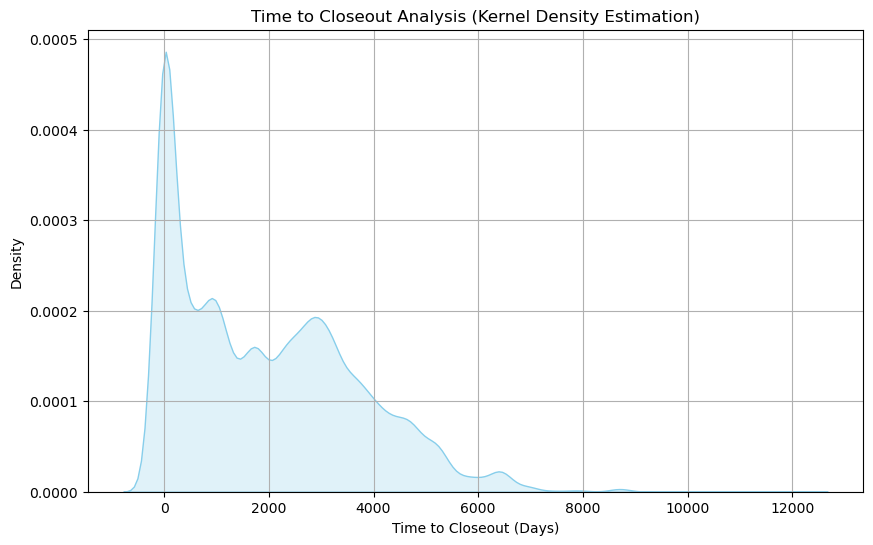

In [63]:
closeout_dates = dataset['disaster_closeout_date']
declaration_dates = dataset['declaration_date']

# Calculate the time taken for closeout after declaration
time_to_closeout = closeout_dates - declaration_dates

# Convert the time difference to days 
time_to_closeout_days = time_to_closeout.dt.days

# Plotting
plt.figure(figsize=(10, 6))
sns.kdeplot(time_to_closeout_days, color='skyblue', shade=True)
plt.xlabel('Time to Closeout (Days)')
plt.ylabel('Density')
plt.title('Time to Closeout Analysis (Kernel Density Estimation)')
plt.grid(True)
plt.show()


### Subplots
##### Generates a 2x2 grid of subplots using Seaborn and Matplotlib. Each subplot represents the count of occurrences of boolean values (True/False) in specific columns of a dataset.

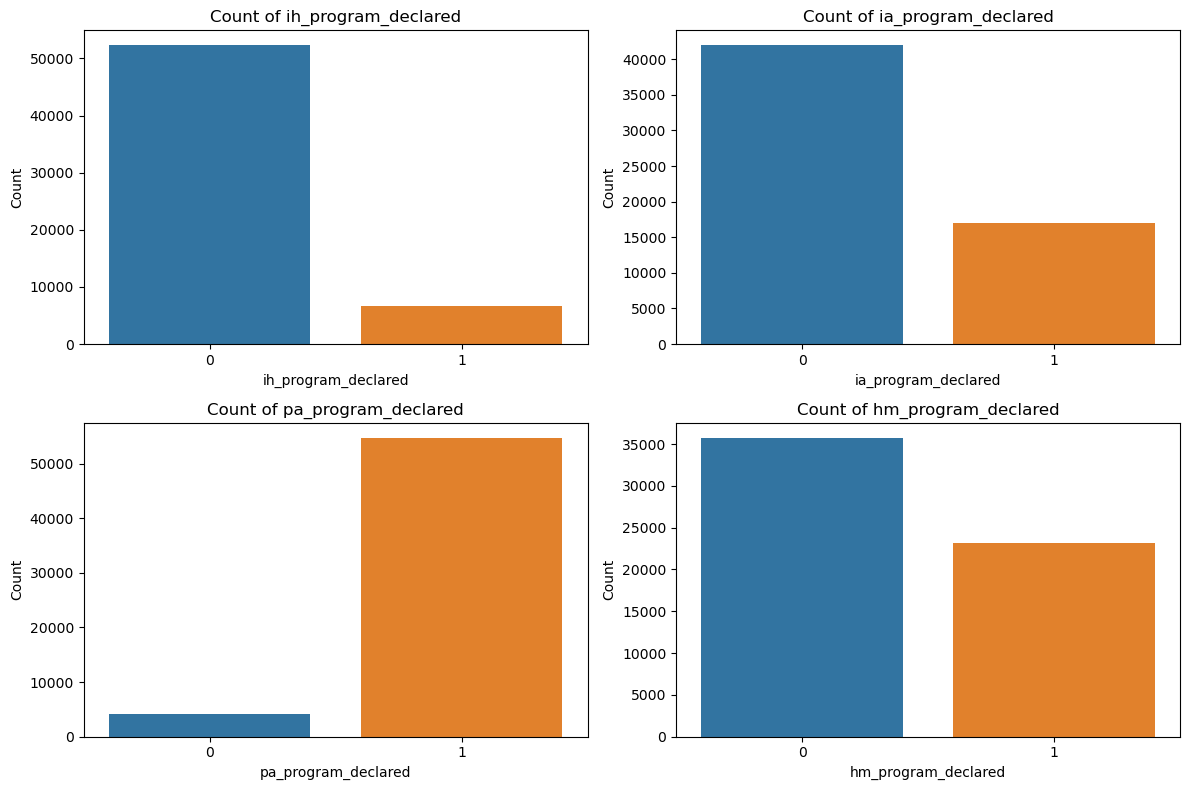

In [64]:
# List of boolean columns
boolean_columns = ['ih_program_declared', 'ia_program_declared', 'pa_program_declared', 'hm_program_declared']

# Create subplots
plt.figure(figsize=(12, 8))
for i, column in enumerate(boolean_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=dataset[column])
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()




# Scalling Using Robust Scaler

In [65]:
dataset.head(5)

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,incident_duration
89,dr-91-in,91,in,1,1959-01-29,1959,flood,flood,0,1,1,0,1959-01-29,1959-01-29,1960-11-01,18021,99021,clay,59015,0
181,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41001,99001,baker,64031,0
182,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41003,99003,benton,64031,0
183,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41005,99005,clackamas,64031,0
184,dr-184-or,184,or,1,1964-12-24,1965,flood,heavy rains & flooding,0,1,1,0,1964-12-24,1964-12-24,1968-08-12,41007,99007,clatsop,64031,0


In [66]:
# List of columns to drop
columns_to_drop = ['declaration_request_number', 'place_code', 'fips', 'disaster_closeout_date', 'ih_program_declared','ia_program_declared','pa_program_declared','hm_program_declared',
                   'incident_end_date', 'incident_begin_date', 'fema_declaration_string', 'disaster_number', 'declaration_date', 'fy_declared']

# Drop the columns from the DataFrame
dataset.drop(columns=columns_to_drop, inplace=True)
dataset.head(5)

,state,declaration_type,incident_type,declaration_title,designated_area,incident_duration
89,in,1,flood,flood,clay,0
181,or,1,flood,heavy rains & flooding,baker,0
182,or,1,flood,heavy rains & flooding,benton,0
183,or,1,flood,heavy rains & flooding,clackamas,0
184,or,1,flood,heavy rains & flooding,clatsop,0


In [67]:
print(dataset.columns)

Index(['state', 'declaration_type', 'incident_type', 'declaration_title',
       'designated_area', 'incident_duration'],
      dtype='object')


In [68]:
# Assuming 'dataset' is your pandas DataFrame

# Define the columns to be label encoded
label_encoding_columns = ['state', 'incident_type', 'declaration_title', 'designated_area']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Create new columns for label encoding
for column in label_encoding_columns:
    dataset[column+'_label_encoded'] = label_encoder.fit_transform(dataset[column])

# Initialize RobustScaler
robust_scaler = RobustScaler()

# Create new columns for robust scaling
for column in dataset.columns:
    if column not in label_encoding_columns:  # Skip columns already label encoded
        dataset[column+'_robust_scaled'] = robust_scaler.fit_transform(dataset[[column]])

# Optionally, drop the original label-encoded columns if needed
# dataset.drop(columns=[column+'_label_encoded' for column in label_encoding_columns], inplace=True)

In [69]:
dataset.head(5)

,state,declaration_type,incident_type,declaration_title,designated_area,incident_duration,state_label_encoded,incident_type_label_encoded,declaration_title_label_encoded,designated_area_label_encoded,declaration_type_robust_scaled,incident_duration_robust_scaled,state_label_encoded_robust_scaled,incident_type_label_encoded_robust_scaled,declaration_title_label_encoded_robust_scaled,designated_area_label_encoded_robust_scaled
89,in,1,flood,flood,clay,0,18,8,446,432,0.0,-0.433333,-0.500000,-0.428571,-1.127436,-0.668902
181,or,1,flood,heavy rains & flooding,baker,0,42,8,545,117,0.0,-0.433333,0.423077,-0.428571,-0.979010,-0.950592
182,or,1,flood,heavy rains & flooding,benton,0,42,8,545,174,0.0,-0.433333,0.423077,-0.428571,-0.979010,-0.899620
183,or,1,flood,heavy rains & flooding,clackamas,0,42,8,545,423,0.0,-0.433333,0.423077,-0.428571,-0.979010,-0.676951
184,or,1,flood,heavy rains & flooding,clatsop,0,42,8,545,431,0.0,-0.433333,0.423077,-0.428571,-0.979010,-0.669797


In [70]:
# Assuming you have a DataFrame named 'dataset' with the columns 'state', 'state_label_encoded', and 'state_label_encoded_robust_scaled'
unique_values = dataset['state_label_encoded'].unique()
unique_values_sorted = sorted(unique_values)  # Sort unique values in ascending order

# Create a dictionary to map state_label_encoded values to state names
state_map = dataset.set_index('state_label_encoded')['state'].to_dict()

print("Unique values in ascending order and their corresponding state names and state_label_encoded_robust_scaled values:")
for value in unique_values_sorted:
    state_name = state_map.get(value, "State not found")
    corresponding_value_robust_scaled = dataset.loc[dataset['state_label_encoded'] == value, 'state_label_encoded_robust_scaled'].iloc[0]
    print(f"state_encoded: {value}, State: {state_name}, state_scaled: {corresponding_value_robust_scaled}")

Unique values in ascending order and their corresponding state names and state_label_encoded_robust_scaled values:
state_encoded: 0, State: ak, state_scaled: -1.1923076923076923
state_encoded: 1, State: al, state_scaled: -1.1538461538461537
state_encoded: 2, State: ar, state_scaled: -1.1153846153846154
state_encoded: 3, State: as, state_scaled: -1.0769230769230769
state_encoded: 4, State: az, state_scaled: -1.0384615384615385
state_encoded: 5, State: ca, state_scaled: -1.0
state_encoded: 6, State: co, state_scaled: -0.9615384615384616
state_encoded: 7, State: ct, state_scaled: -0.9230769230769231
state_encoded: 8, State: dc, state_scaled: -0.8846153846153846
state_encoded: 9, State: de, state_scaled: -0.8461538461538461
state_encoded: 10, State: fl, state_scaled: -0.8076923076923077
state_encoded: 11, State: fm, state_scaled: -0.7692307692307693
state_encoded: 12, State: ga, state_scaled: -0.7307692307692307
state_encoded: 13, State: gu, state_scaled: -0.6923076923076923
state_encoded:

In [71]:
# Assuming you have a DataFrame named 'dataset' with the columns 'incident_type', 'incident_type_label_encoded', and 'incident_type_label_encoded_robust_scaled'
unique_values = dataset['incident_type_label_encoded'].unique()
unique_values_sorted = sorted(unique_values)  # Sort unique values in ascending order

# Create a dictionary to map incident_type_label_encoded values to incident_type names
incident_type_map = dataset.set_index('incident_type_label_encoded')['incident_type'].to_dict()

print("Unique values in ascending order and their corresponding incident_type names and incident_type_label_encoded_robust_scaled values:")
for value in unique_values_sorted:
    incident_type_name = incident_type_map.get(value, "Incident Type not found")
    corresponding_value_robust_scaled = dataset.loc[dataset['incident_type_label_encoded'] == value, 'incident_type_label_encoded_robust_scaled'].iloc[0]
    print(f"Incident_encoded: {value}, Incident Type: {incident_type_name}, incident_scaled: {corresponding_value_robust_scaled}")

Unique values in ascending order and their corresponding incident_type names and incident_type_label_encoded_robust_scaled values:
Incident_encoded: 0, Incident Type: biological, incident_scaled: -1.5714285714285714
Incident_encoded: 1, Incident Type: chemical, incident_scaled: -1.4285714285714286
Incident_encoded: 2, Incident Type: coastal storm, incident_scaled: -1.2857142857142858
Incident_encoded: 3, Incident Type: dam/levee break, incident_scaled: -1.1428571428571428
Incident_encoded: 4, Incident Type: drought, incident_scaled: -1.0
Incident_encoded: 5, Incident Type: earthquake, incident_scaled: -0.8571428571428571
Incident_encoded: 6, Incident Type: fire, incident_scaled: -0.7142857142857143
Incident_encoded: 7, Incident Type: fishing losses, incident_scaled: -0.5714285714285714
Incident_encoded: 8, Incident Type: flood, incident_scaled: -0.42857142857142855
Incident_encoded: 9, Incident Type: freezing, incident_scaled: -0.2857142857142857
Incident_encoded: 10, Incident Type: hu

# Descriptive analysis

In [72]:
# Descriptive Analytics
desc_stats = dataset.describe()

# Check for missing values
missing_values = dataset.isnull().sum()

desc_stats, missing_values

(       declaration_type  incident_duration  state_label_encoded  \
 count      58944.000000       58944.000000         58944.000000   
 mean           1.366585          45.270019            30.681935   
 std            0.532072         132.389601            16.123383   
 min            1.000000           0.000000             0.000000   
 25%            1.000000           3.000000            18.000000   
 50%            1.000000          13.000000            31.000000   
 75%            2.000000          33.000000            44.000000   
 max            3.000000        5117.000000            58.000000   
 
        incident_type_label_encoded  declaration_title_label_encoded  \
 count                 58944.000000                     58944.000000   
 mean                     11.157064                      1026.480778   
 std                       4.554749                       431.707992   
 min                       0.000000                         0.000000   
 25%                      

# Select features for PCA

In [73]:
# Select relevant features for PCA
incident_dataframe = dataset[['state_label_encoded_robust_scaled', 'incident_type_label_encoded_robust_scaled']]

# K Means

In [74]:
def silhouette_method(data, max_clusters=10):
    silhouette_scores = []
    for i in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, cluster_labels))

    # Find the optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 because range starts from 2
    optimal_silhouette_score = max(silhouette_scores)
    return optimal_k, optimal_silhouette_score

# Example usage
optimal_k_silhouette, silhouette_score = silhouette_method(incident_dataframe)
print("Optimal number of clusters using silhouette score:", optimal_k_silhouette)
print("Highest silhouette score:", silhouette_score)


Optimal number of clusters using silhouette score: 10
Highest silhouette score: 0.4545618805439378


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\2727807185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_dataframe['K means Cluster'] = kmeans.fit_predict(incident_dataframe)


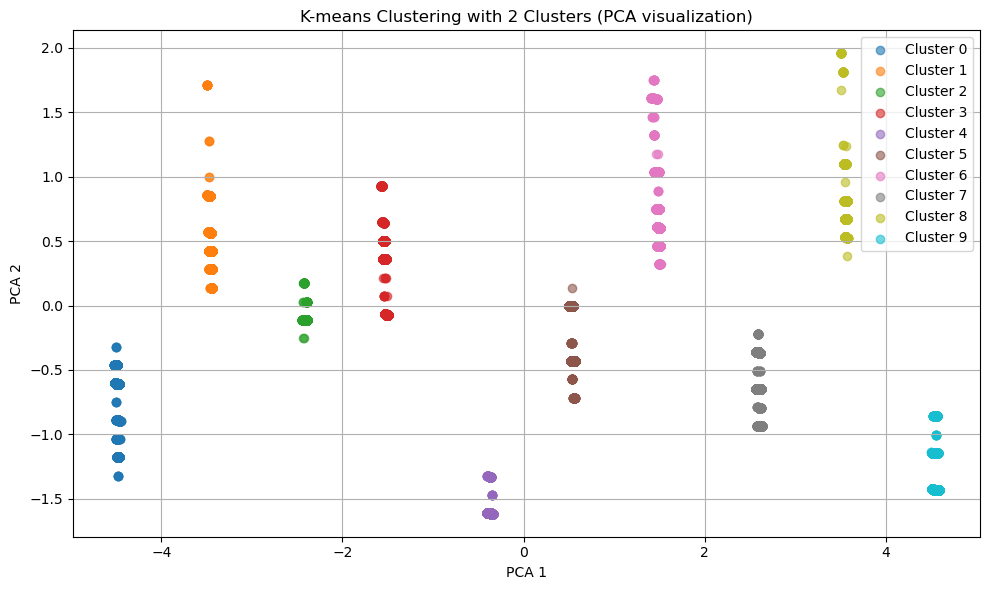

In [75]:
# Perform K-means clustering on PCA-transformed data
kmeans = KMeans(n_clusters=10, random_state=42)
incident_dataframe['K means Cluster'] = kmeans.fit_predict(incident_dataframe)

# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(incident_dataframe)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(10):
    subset = pca_data[incident_dataframe['K means Cluster'] == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('K-means Clustering with 2 Clusters (PCA visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\2794372240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_dataframe['K means Cluster'] = kmeans.fit_predict(incident_dataframe)


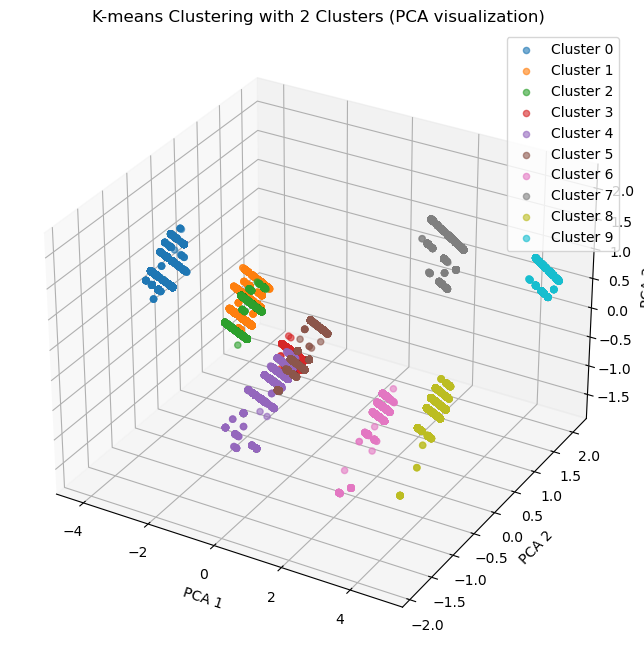

In [76]:
# Perform K-means clustering on PCA-transformed data
kmeans = KMeans(n_clusters=10, random_state=42)
incident_dataframe['K means Cluster'] = kmeans.fit_predict(incident_dataframe)

# Perform PCA
pca = PCA(n_components=3)  # Use 3 principal components for 3D plotting
pca_data = pca.fit_transform(incident_dataframe)

# Initialize the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters in 3D
for cluster_num in range(10):
    subset = pca_data[incident_dataframe['K means Cluster'] == cluster_num]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f"Cluster {cluster_num}", alpha=0.6)

# Set labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('K-means Clustering with 2 Clusters (PCA visualization)')

# Add legend
ax.legend()

plt.show()


In [77]:
# Calculate mean for each cluster for the specified columns
column_means = {}
for col in ['state_label_encoded_robust_scaled', 'incident_type_label_encoded_robust_scaled']:
    column_means[col] = []
    for cluster_num in range(10):
        subset = incident_dataframe[incident_dataframe['K means Cluster'] == cluster_num]
        cluster_mean = np.mean(subset[col])
        column_means[col].append(cluster_mean)

# Prepare data for tabulate
table_data = []
for i in range(10):
    cluster_num = i
    mean_state_label_encoded = column_means['state_label_encoded_robust_scaled'][i]
    mean_incident_type_label_encoded = column_means['incident_type_label_encoded_robust_scaled'][i]
    table_data.append([f"Cluster {i}", mean_state_label_encoded, mean_incident_type_label_encoded])

# Display table
headers = ['Cluster', 'Mean state_label_encoded', 'Mean incident_type_label_encoded']
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


+-----------+--------------------------+----------------------------------+
|  Cluster  | Mean state_label_encoded | Mean incident_type_label_encoded |
+-----------+--------------------------+----------------------------------+
| Cluster 0 |   -0.8305234410559853    |        -0.545832628909552        |
| Cluster 1 |    0.656128536563319     |       -0.5749958032566728        |
| Cluster 2 |   -0.1465296393064368    |       -0.2076690402671876        |
| Cluster 3 |    0.6420863858363859    |       0.004166666666666665       |
| Cluster 4 |   -0.3867889267170983    |        0.6300834477659237        |
| Cluster 5 |   -0.9346339314693742    |        0.2963489193145612        |
| Cluster 6 |    0.7832611910932602    |        0.6056245747549327        |
| Cluster 7 |   -0.4202422868055141    |       -1.4516790424470798        |
| Cluster 8 |   0.24339020905853237    |        0.596222114270767         |
| Cluster 9 |    0.5864160742411988    |       -1.5360898094711046        |
+-----------

# Gaussian Mixture 

In [78]:
from sklearn.metrics import silhouette_score

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(incident_dataframe)

# Define the range of cluster numbers to try
min_clusters = 2  # Minimum number of clusters should be at least 2 for silhouette score
max_clusters = 10

# Initialize variables to store best silhouette score and best number of components
best_silhouette_score = -1
optimal_n_components = -1

# Iterate over different numbers of components and compute silhouette scores
for n_components in range(min_clusters, max_clusters+1):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)
    silhouette = silhouette_score(X_pca, labels)
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        optimal_n_components = n_components

# Print the optimal number of components and corresponding silhouette score
print(f"Optimal number of components: {optimal_n_components}")
print(f"Highest silhouette score: {best_silhouette_score}")


Optimal number of components: 10
Highest silhouette score: 0.8160566412175718


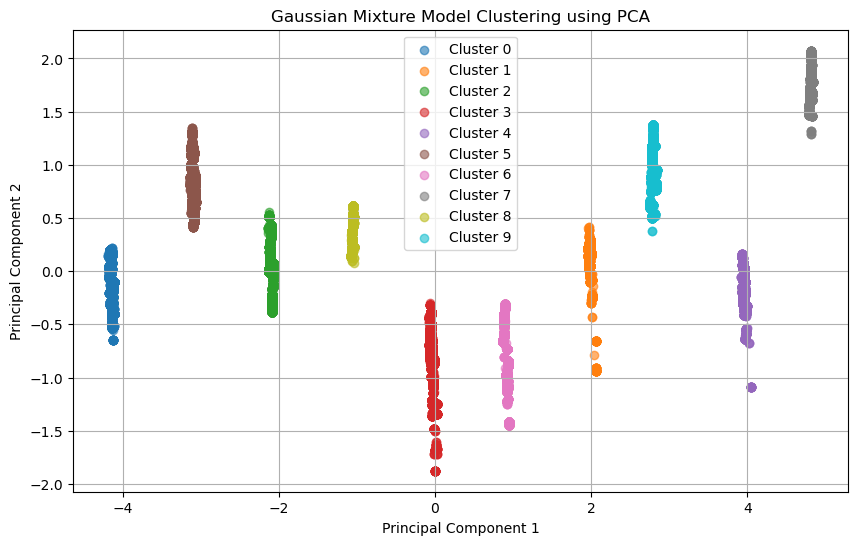

In [79]:
# Use the best GMM model to predict the cluster labels
best_gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
best_gmm.fit(X_pca)
cluster_labels = best_gmm.predict(X_pca)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(optimal_n_components):
    subset = X_pca[cluster_labels == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('Gaussian Mixture Model Clustering using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\1254265086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_dataframe['Gaussian Mixture Cluster'] = cluster_labels


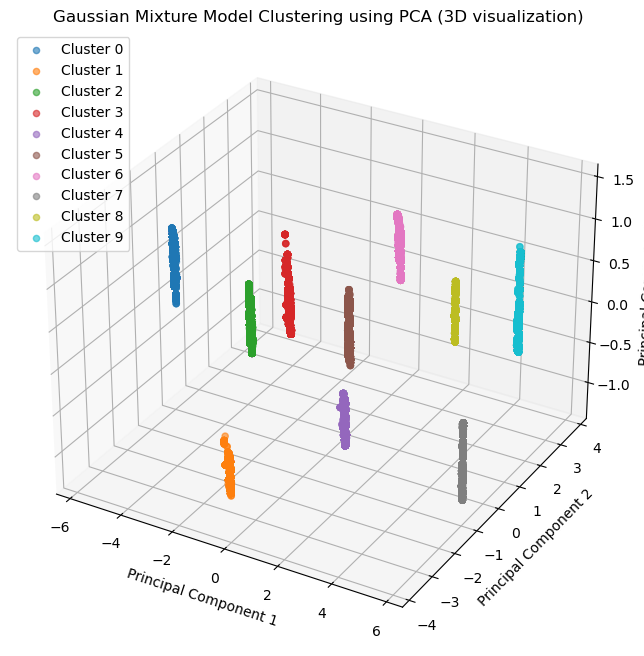

In [80]:
# Use the best GMM model to predict the cluster labels
cluster_labels = best_gmm.predict(X_pca)

# Assign cluster labels to dataframe
incident_dataframe['Gaussian Mixture Cluster'] = cluster_labels

# Perform PCA with 3 components for 3D plotting
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(incident_dataframe)

# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster_num in range(best_gmm.n_components):
    subset = X_pca_3d[incident_dataframe['Gaussian Mixture Cluster'] == cluster_num]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f"Cluster {cluster_num}", alpha=0.6)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Gaussian Mixture Model Clustering using PCA (3D visualization)')

# Add legend
ax.legend()

plt.show()

In [81]:
# Calculate mean for each cluster for the specified columns
column_means = {}
for col in ['state_label_encoded_robust_scaled', 'incident_type_label_encoded_robust_scaled']:
    column_means[col] = []
    for cluster_num in range(10):
        subset = incident_dataframe[incident_dataframe['Gaussian Mixture Cluster'] == cluster_num]
        cluster_mean = np.mean(subset[col])
        column_means[col].append(cluster_mean)

# Prepare data for tabulate
table_data = []
for i in range(10):
    cluster_num = i
    mean_state_label_encoded = column_means['state_label_encoded_robust_scaled'][i]
    mean_incident_type_label_encoded = column_means['incident_type_label_encoded_robust_scaled'][i]
    table_data.append([f"Cluster {i}", mean_state_label_encoded, mean_incident_type_label_encoded])

# Display table
headers = ['Cluster', 'Mean state_label_encoded', 'Mean incident_type_label_encoded']
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


+-----------+--------------------------+----------------------------------+
|  Cluster  | Mean state_label_encoded | Mean incident_type_label_encoded |
+-----------+--------------------------+----------------------------------+
| Cluster 0 |   -0.8305234410559853    |        -0.545832628909552        |
| Cluster 1 |    0.7832611910932602    |        0.6056245747549327        |
| Cluster 2 |   -0.1465296393064368    |       -0.2076690402671876        |
| Cluster 3 |   -0.3867889267170983    |        0.6300834477659237        |
| Cluster 4 |   0.24339020905853237    |        0.596222114270767         |
| Cluster 5 |    0.656128536563319     |       -0.5749958032566728        |
| Cluster 6 |   -0.9346339314693742    |        0.2963489193145612        |
| Cluster 7 |    0.5864160742411988    |       -1.5360898094711046        |
| Cluster 8 |    0.6420863858363859    |       0.004166666666666665       |
| Cluster 9 |   -0.4202422868055141    |       -1.4516790424470798        |
+-----------

# Self-organizing Maps (SOM)

In [82]:
# Extract only the first two principal components for training the SOM
features_for_pca = pca_data[:, :2]

min_components = 2
max_components = 10

# Initialize variables to store best silhouette score and best number of components
best_silhouette_score = -1
optimal_n_components = -1

# Iterate over different numbers of components and compute silhouette scores
for n_components in range(min_components, max_components + 1):
    # Create a SOM grid
    som = MiniSom(10, 10, 2, sigma=1.0, learning_rate=0.5)
    som.random_weights_init(features_for_pca)
    som.train_random(features_for_pca, 100)

    # Get the clustered data
    clustered_data = som.win_map(features_for_pca)

    # Assign labels to data points
    labels = np.array([som.winner(data_point) for data_point in features_for_pca])
    labels = np.ravel_multi_index(labels.T, (10, 10))

    # Compute silhouette score
    silhouette = silhouette_score(features_for_pca, labels)
    
    # Update best silhouette score and number of components if needed
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        optimal_n_components = n_components

# Print the optimal number of components and the highest silhouette score
print(f"Optimal number of components: {optimal_n_components}")
print(f"Highest silhouette score: {best_silhouette_score}")


Optimal number of components: 3
Highest silhouette score: 0.6003286674492679


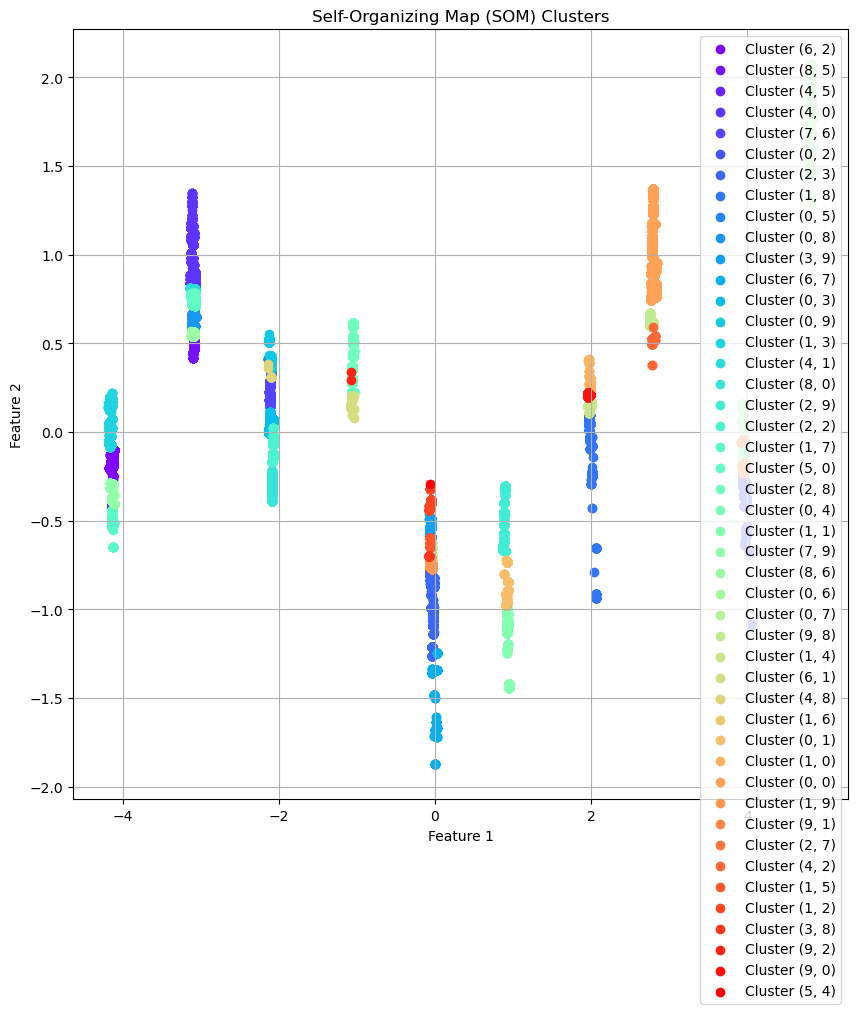

In [83]:
# Extract only the first two principal components for training the SOM
features_for_pca = pca_data[:, :2]

# Create a SOM grid with 10x10 nodes
som = MiniSom(10, 10, 2, sigma=1.0, learning_rate=0.5)  # Adjust input_len to match the number of PCA components

# Initialize weights with random values
som.random_weights_init(features_for_pca)

# Train the SOM for 100 epochs
som.train_random(features_for_pca, 100)

# Get the clustered data
clustered_data = som.win_map(features_for_pca)

# Visualize the SOM clusters

# Assign colors to each cluster
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(clustered_data))))

# Plot the clustered data
plt.figure(figsize=(10, 10))
for cluster, data_points in clustered_data.items():
    color = next(colors)
    data_points = np.array(data_points)
    plt.scatter(data_points[:, 0], data_points[:, 1], color=color, label=f'Cluster {cluster}')  # Add cluster label

# Add legend
plt.title('Self-Organizing Map (SOM) Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()  # Show legend
plt.grid(True)
plt.show()


In [84]:
# Calculate mean for each cluster
cluster_means = {}
for cluster, data_points in clustered_data.items():
    cluster_mean = np.mean(data_points, axis=0)
    cluster_means[cluster] = cluster_mean

# Prepare data for tabulate
table_data = []
for cluster, mean in cluster_means.items():
    table_data.append([f'Cluster {cluster}', *mean])

# Display the mean for each cluster
print(tabulate(table_data, headers=["Cluster", "Mean state", "Mean incident type"]))


Cluster           Mean state    Mean incident type
--------------  ------------  --------------------
Cluster (6, 2)  -4.13095               -0.164803
Cluster (8, 5)  -3.09248                0.474428
Cluster (4, 5)  -4.13412               -0.415435
Cluster (4, 0)  -3.09731                0.963703
Cluster (7, 6)  -2.11177                0.206357
Cluster (0, 2)   3.95806               -0.352023
Cluster (2, 3)  -0.0461136             -0.904734
Cluster (1, 8)   1.98419                0.00212681
Cluster (0, 5)  -2.10516                0.333475
Cluster (0, 8)  -3.09048                0.655976
Cluster (3, 9)  -0.0493784             -0.518227
Cluster (6, 7)   0.000363499           -1.46733
Cluster (0, 3)  -2.11209                0.0400999
Cluster (0, 9)  -2.10771                0.402746
Cluster (1, 3)  -4.15823                0.0289123
Cluster (4, 1)  -3.09489                0.808167
Cluster (8, 0)  -2.08956               -0.296516
Cluster (2, 9)   0.885438              -0.488049
Cluster (2, 2

# DBSCAN

In [85]:
# Define the number of components for PCA
num_components = 2  # Adjust this as needed

# Apply PCA to your data to transform it into the desired number of components
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(incident_dataframe)

# Define parameter values to search over
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [3, 5, 10]

best_silhouette_score = -1
best_eps = None
best_min_samples = None
best_cluster_labels = None

# Iterate over different parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(pca_data)
        
        # Check if more than one cluster is formed
        if len(np.unique(cluster_labels)) > 1:
            # Compute silhouette score
            silhouette = silhouette_score(pca_data, cluster_labels)
            
            # Update best silhouette score and parameters if needed
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_cluster_labels = cluster_labels

# Print best parameters and silhouette score
print("Best Parameters:")
print("  - Epsilon:", best_eps)
print("  - Min Samples:", best_min_samples)
print("Silhouette Score:", best_silhouette_score)


Best Parameters:
  - Epsilon: 0.1
  - Min Samples: 3
Silhouette Score: 0.9882786918652894


C:\Users\YapJh\AppData\Local\Temp\ipykernel_12852\3404224462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_dataframe['DBSCAN Cluster'] = dbscan.fit_predict(pca_data)


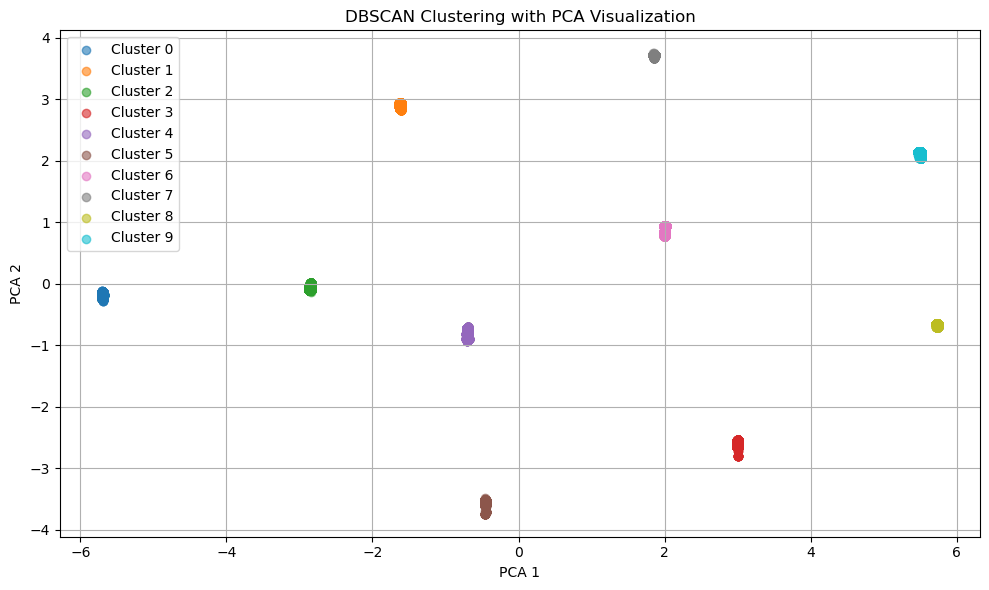

In [86]:
# Perform DBSCAN clustering on PCA-transformed data
dbscan = DBSCAN(eps=0.1, min_samples=3)
incident_dataframe['DBSCAN Cluster'] = dbscan.fit_predict(pca_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in incident_dataframe['DBSCAN Cluster'].unique():
    if cluster_num == -1:
        subset = pca_data[incident_dataframe['DBSCAN Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Outliers", color='black', alpha=0.6)
    else:
        subset = pca_data[incident_dataframe['DBSCAN Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('DBSCAN Clustering with PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
from tabulate import tabulate

# Calculate mean for each cluster for the specified columns
column_means = {}
for col in ['state_label_encoded_robust_scaled', 'incident_type_label_encoded_robust_scaled']:
    column_means[col] = []
    for cluster_num in range(10):
        subset = incident_dataframe[incident_dataframe['DBSCAN Cluster'] == cluster_num]
        cluster_mean = np.mean(subset[col])
        column_means[col].append(cluster_mean)

# Prepare data for tabulate
table_data = []
for i in range(10):
    cluster_num = i
    mean_state_label_encoded = column_means['state_label_encoded_robust_scaled'][i]
    mean_incident_type_label_encoded = column_means['incident_type_label_encoded_robust_scaled'][i]
    table_data.append([f"Cluster {i}", mean_state_label_encoded, mean_incident_type_label_encoded])

# Display table
headers = ['Cluster', 'Mean state_label_encoded', 'Mean incident_type_label_encoded']
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


+-----------+--------------------------+----------------------------------+
|  Cluster  | Mean state_label_encoded | Mean incident_type_label_encoded |
+-----------+--------------------------+----------------------------------+
| Cluster 0 |   -0.8305234410559853    |        -0.545832628909552        |
| Cluster 1 |    0.656128536563319     |       -0.5749958032566728        |
| Cluster 2 |   -0.1465296393064368    |       -0.2076690402671876        |
| Cluster 3 |   0.24339020905853237    |        0.596222114270767         |
| Cluster 4 |   -0.3867889267170983    |        0.6300834477659237        |
| Cluster 5 |    0.7832611910932602    |        0.6056245747549327        |
| Cluster 6 |   -0.9346339314693742    |        0.2963489193145612        |
| Cluster 7 |    0.6420863858363859    |       0.004166666666666665       |
| Cluster 8 |    0.5864160742411988    |       -1.5360898094711046        |
| Cluster 9 |   -0.4202422868055141    |       -1.4516790424470798        |
+-----------

# Mean Shift 

In [88]:
# Apply PCA to your data to transform it into the desired number of components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(incident_dataframe)

# Apply Mean Shift clustering
meanshift = MeanShift()
cluster_labels = meanshift.fit_predict(pca_data)

# Compute Silhouette Score
silhouette = silhouette_score(pca_data, cluster_labels)
print("Silhouette Score:", silhouette)

# Get the number of clusters
num_clusters = len(np.unique(cluster_labels))
print("Number of clusters:", num_clusters)


Silhouette Score: 0.47152311635924793
Number of clusters: 3


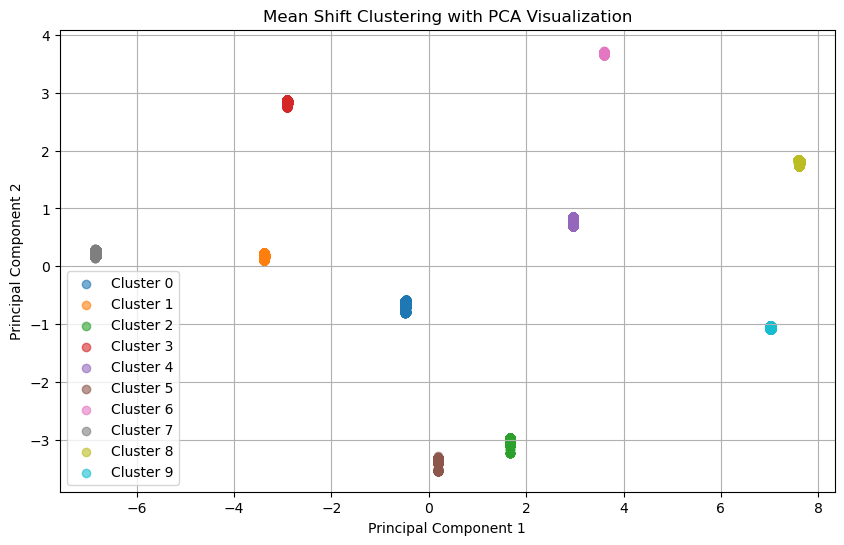

In [89]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Create and fit the Mean Shift model with a smaller bandwidth
meanshift = MeanShift(bandwidth=0.5)  # Adjust the bandwidth value as needed
cluster_labels = meanshift.fit_predict(pca_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(len(set(cluster_labels))):
    subset = pca_data[cluster_labels == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('Mean Shift Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


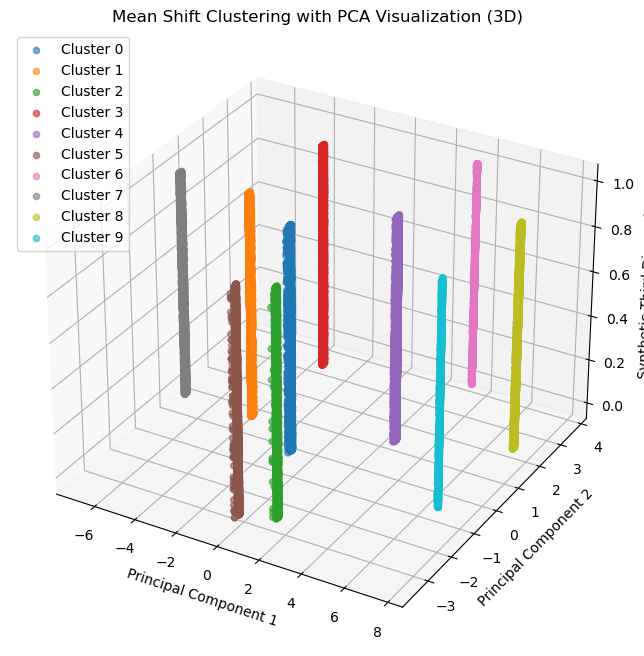

In [90]:
# Create synthetic third dimension (replace this with your actual data if available)
synthetic_third_dim = np.random.rand(len(pca_data))

# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster_num in range(len(set(cluster_labels))):
    subset = pca_data[cluster_labels == cluster_num]
    ax.scatter(subset[:, 0], subset[:, 1], synthetic_third_dim[cluster_labels == cluster_num], label=f"Cluster {cluster_num}", alpha=0.6)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Synthetic Third Dimension')
ax.set_title('Mean Shift Clustering with PCA Visualization (3D)')

# Add legend
ax.legend()
plt.show()


In [91]:
# Create and fit the Mean Shift model with a smaller bandwidth
meanshift = MeanShift(bandwidth=0.5)  # Adjust the bandwidth value as needed
cluster_labels = meanshift.fit_predict(pca_data)

# Calculate the mean of each cluster
cluster_means = {}
for cluster_num in np.unique(cluster_labels):
    if cluster_num == -1:
        continue  # Skip outliers
    cluster_mean = np.mean(pca_data[cluster_labels == cluster_num], axis=0)
    cluster_means[f"Cluster {cluster_num}"] = cluster_mean

# Convert the cluster means to a list of lists for tabulate
table_data = [[cluster, *mean] for cluster, mean in cluster_means.items()]

# Print the tabulated cluster means
print(tabulate(table_data, headers=["Cluster", "Mean state", "Mean incident type"], tablefmt="grid"))

+-----------+--------------+----------------------+
| Cluster   |   Mean state |   Mean incident type |
+===========+==============+======================+
| Cluster 0 |    -0.478226 |            -0.637911 |
+-----------+--------------+----------------------+
| Cluster 1 |    -3.38117  |             0.145023 |
+-----------+--------------+----------------------+
| Cluster 2 |     1.67287  |            -3.02055  |
+-----------+--------------+----------------------+
| Cluster 3 |    -2.91019  |             2.802    |
+-----------+--------------+----------------------+
| Cluster 4 |     2.96011  |             0.807081 |
+-----------+--------------+----------------------+
| Cluster 5 |     0.189813 |            -3.33741  |
+-----------+--------------+----------------------+
| Cluster 6 |     3.59878  |             3.70038  |
+-----------+--------------+----------------------+
| Cluster 7 |    -6.84898  |             0.206388 |
+-----------+--------------+----------------------+
| Cluster 8 